In [1]:
import numpy as np

# package for 3d visualization
import matplotlib.pyplot as plt

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper, dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from aicssegmentation.core.utils import hole_filling
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops,regionprops_table
from scipy.ndimage import distance_transform_edt
from scipy.stats import norm

# for dataframe compatibility of zdr object properties and matplotlib features for lightning plot
import pandas as pd
import glob
import skimage
from aicsimageio import AICSImage
from aicssegmentation.cli.to_analysis import simple_builder, masked_builder
from datetime import datetime 
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from datetime import timedelta
import matplotlib

import pyart
from copy import deepcopy
from skimage.external import tifffile
from natsort import natsorted
import matplotlib.pyplot as plt
import os
import xarray as xr

plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 13


%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def suggest_normalization_param_custom(structure_img0):
    m, s = norm.fit(structure_img0.flat)
#     print(f'mean intensity of the stack: {m}')
#     print(f'the standard deviation of intensity of the stack: {s}')

    p99 = np.percentile(structure_img0, 99.99)
#     print(f'0.9999 percentile of the stack intensity is: {p99}')

    pmin = structure_img0.min()
#     print(f'minimum intensity of the stack: {pmin}')

    pmax = structure_img0.max()
#     print(f'maximum intensity of the stack: {pmax}')

    up_ratio = 0
    for up_i in np.arange(0.5, 1000, 0.5):
        if m+s * up_i > p99:
            if m+s * up_i > pmax:
#                 print(f'suggested upper range is {up_i-0.5}, which is {m+s*(up_i-0.5)}')
                up_ratio = up_i-0.5
            else:
#                 print(f'suggested upper range is {up_i}, which is {m+s*up_i}')
                up_ratio = up_i
            break

    low_ratio = 0
    for low_i in np.arange(0.5, 1000, 0.5):
        if m-s*low_i < pmin:
#             print(f'suggested lower range is {low_i-0.5}, which is {m-s*(low_i-0.5)}')
            low_ratio = low_i-0.5
            break
    return low_ratio,up_ratio

#### Read grid files and start segmentation

In [3]:
# grid_files = sorted(glob.glob('/Users/ms/Desktop/RadxPid_KTLX_May192013/gridded_other_fields/20130519/small_domain/*.nc'))
# cfrad_files = sorted(glob.glob('/Users/ms/Desktop/RadxPid_KTLX_May192013/cfradial_files/20130519/*.nc'))
pyart_grid_files = sorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc'))
normal = matplotlib.colors.Normalize(vmin=1, vmax=7)
cm = matplotlib.cm.ScalarMappable(norm=normal,cmap='cubehelix')

In [4]:
pyart_grid_files[24]

'/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/griddedktlx_20130519_214500.nc'

In [5]:
grid = xr.open_dataset(pyart_grid_files[24])

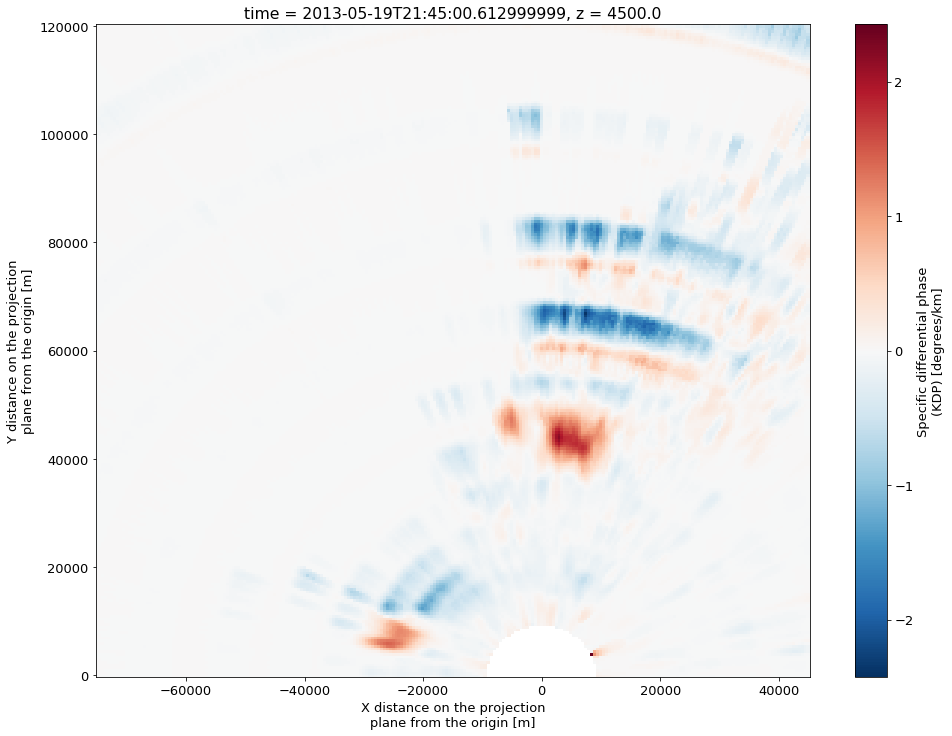

In [88]:
grid.kdp.squeeze().isel(z=9).plot()

In [17]:
# grid = xr.open_dataset(grid_files[24])
# arrays = [cm.to_rgba(grid.ZDR.where(grid.ZDR >= 1).squeeze().data[i,:,:]) for i in range(40)]
# zdr_stack = np.stack(arrays)
# zdr_stack = np.interp(zdr_stack, (zdr_stack.min(), zdr_stack.max()), (255, 0))
# zdr_stack = zdr_stack[7:22]

grid = xr.open_dataset(pyart_grid_files[24])
arrays = [cm.to_rgba(grid.kdp.where(grid.kdp >= 0.75).squeeze().data[i,:,:]) for i in range(31)]
kdp_stack = np.stack(arrays)
kdp_stack = np.interp(kdp_stack, (kdp_stack.min(), kdp_stack.max()), (255, 0))
kdp_stack = kdp_stack[8:23]

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [71]:
# reader = AICSImage(zdr_stack,dims="ZYXC")

# IMG = reader.data
# struct_img0 = IMG[0,:,:,1,:].copy()

reader = AICSImage(kdp_stack,dims="ZYXC")

IMG = reader.data
struct_img0 = IMG[0,:,:,2,:].copy()

In [72]:
intensity_scaling_param = [50,0]
gaussian_smoothing_sigma = 1

struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img0, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 50 x std, mean + 0 x std] 
intensity normalization completes


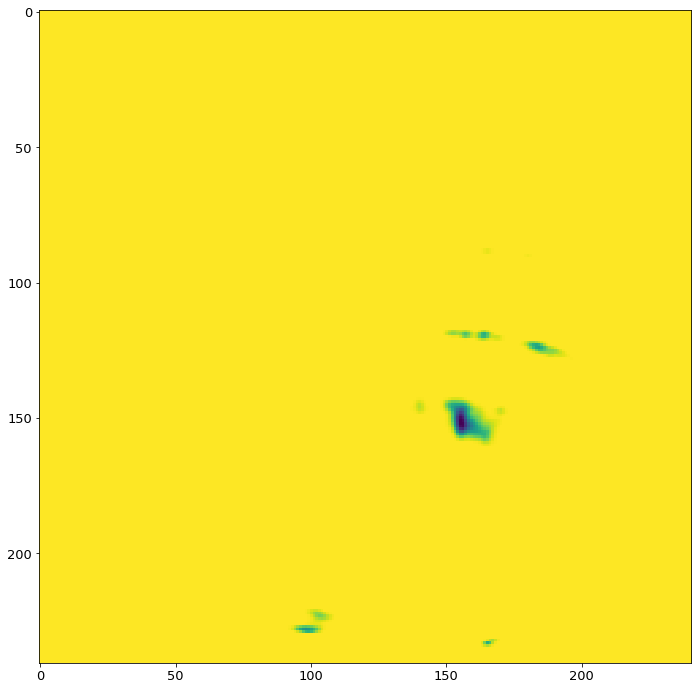

In [73]:
plt.imshow(structure_img_smooth[::-1,:,0])

In [89]:
s2_param = [[1.25,0.05],[1.15,0.9]]
# s2_param = [[1.1,0.01]]

# s2_param = [[1.25,0.9],[1,0.07],[1,0.01],[1.5,0.005]]
fill_2d = True
fill_max_size = 1
################################

bw_spot = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

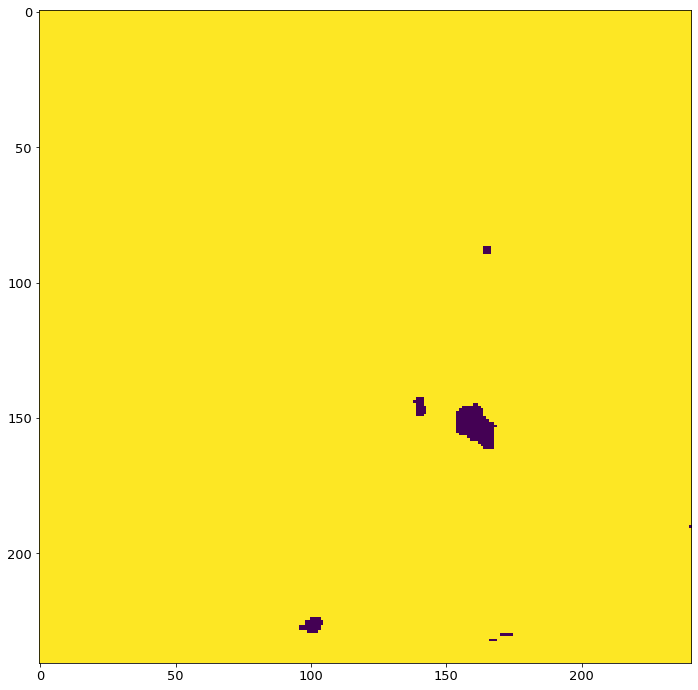

In [90]:
plt.imshow(bw_spot[::-1,:,2])

In [79]:
################################
## PARAMETERS for this step ##
# f2_param = [[3, 0.5]]
# f2_param = [[1.25, 0.07]]

f2_param = [[1.25, 0.07],[1.25,0.05]]
fill_2d = True
fill_max_size = 100000
################################

bw_filament = filament_2d_wrapper(structure_img_smooth, f2_param)

/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


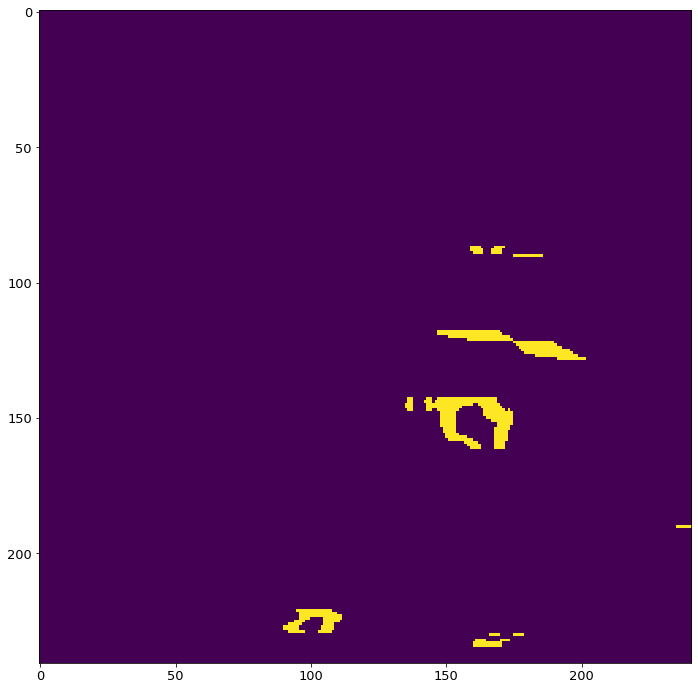

In [80]:
plt.imshow(bw_filament[::-1,:,2])

In [81]:
bw = np.logical_or(bw_spot, bw_filament)
bw_fill = hole_filling(bw, 100, fill_max_size, fill_2d)
bw_fill = np.invert(bw_fill)

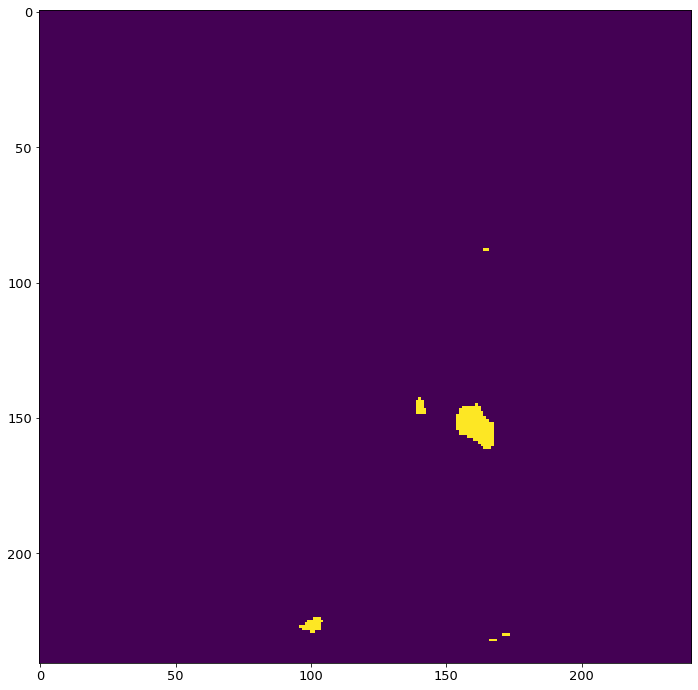

In [84]:
plt.imshow(bw_fill[::-1,:,2])

In [85]:
minArea = 50
Mask = remove_small_objects(bw_spot>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max(struct_img,labels=label(Mask), min_distance=1, indices=False), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw_spot)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

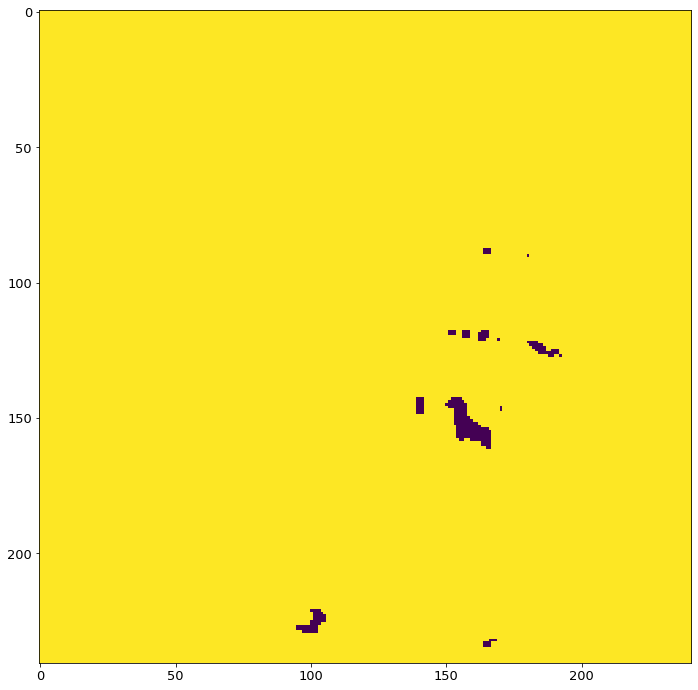

In [87]:
plt.imshow(seg[::-1,:,1])

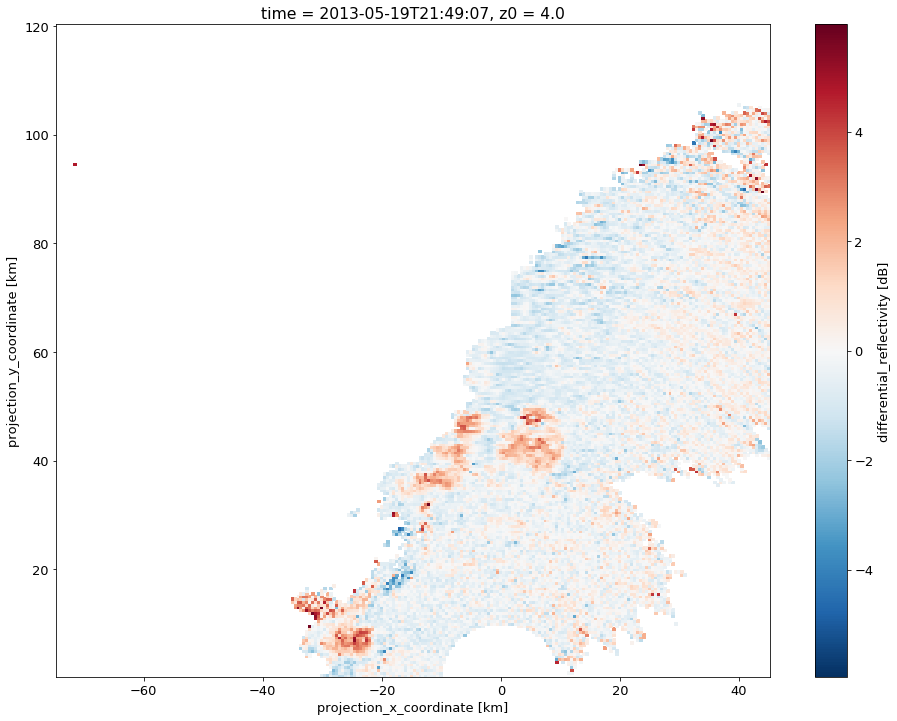

In [41]:
grid.ZDR.isel(time=0,z0=7).plot()

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


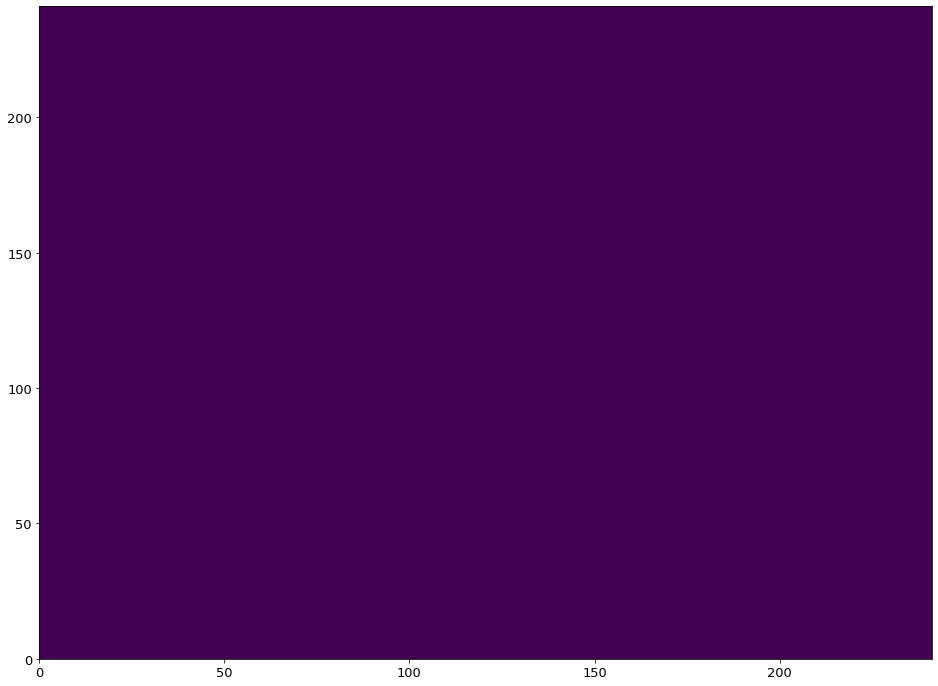

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


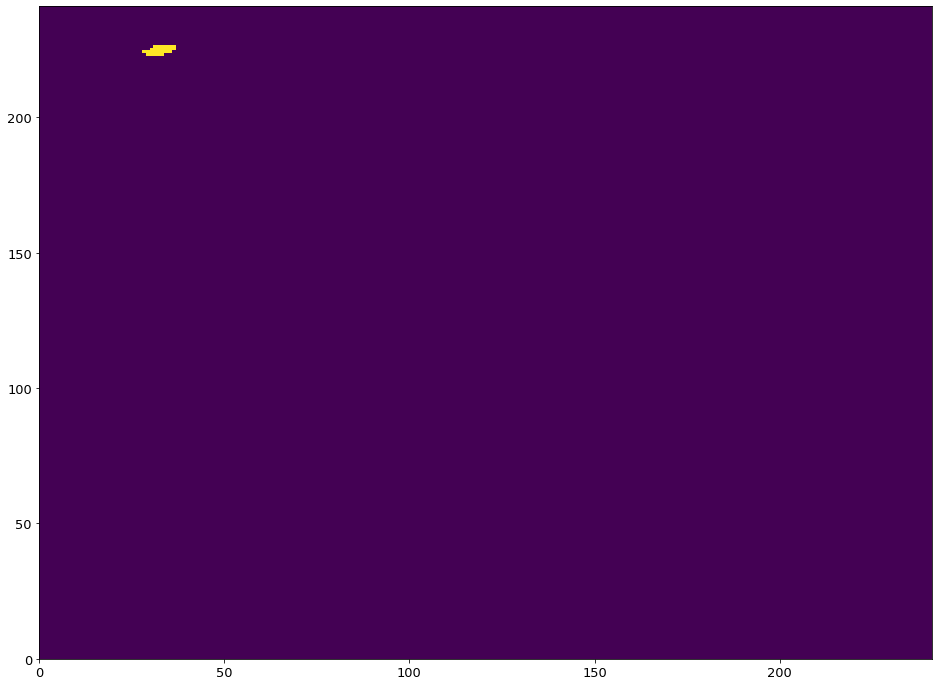

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


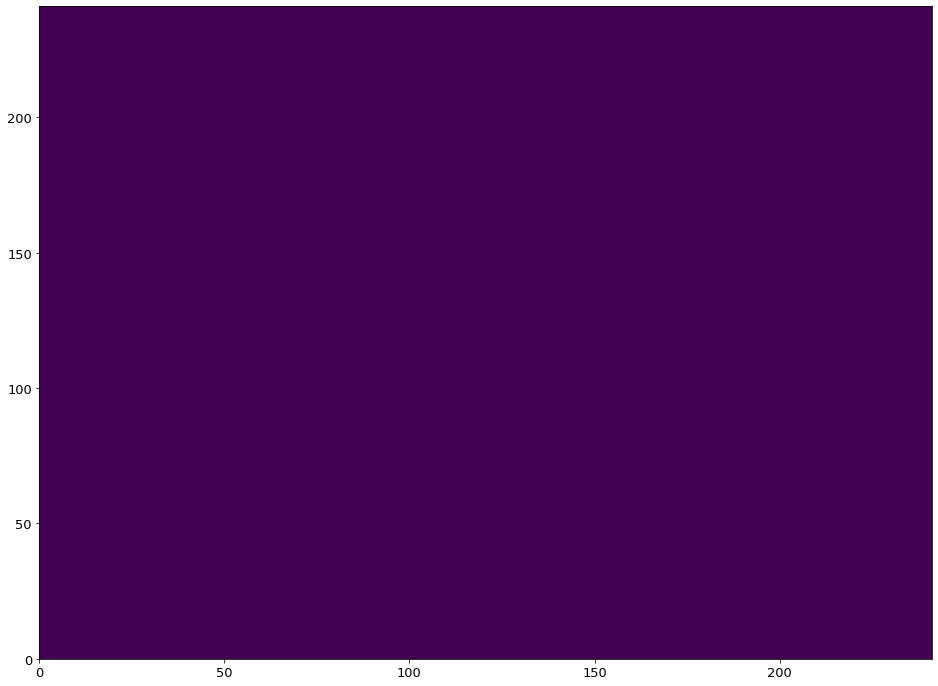

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


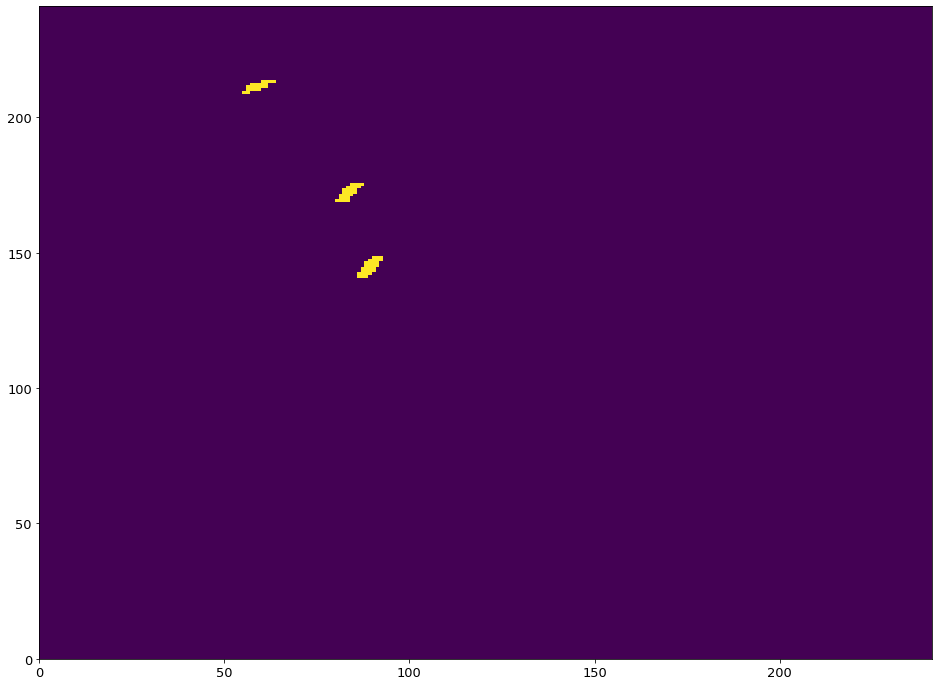

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


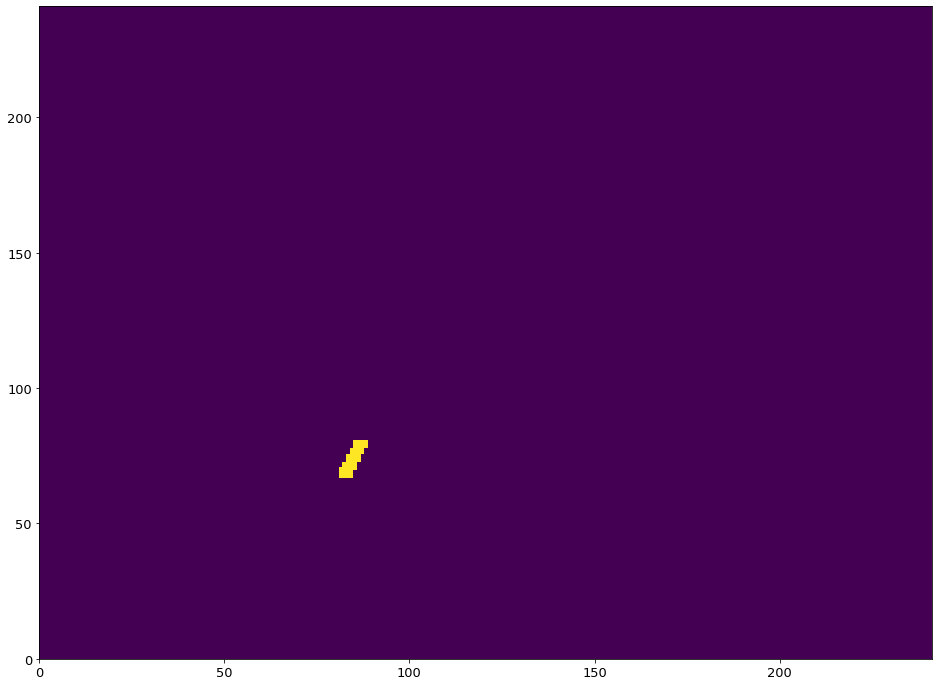

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


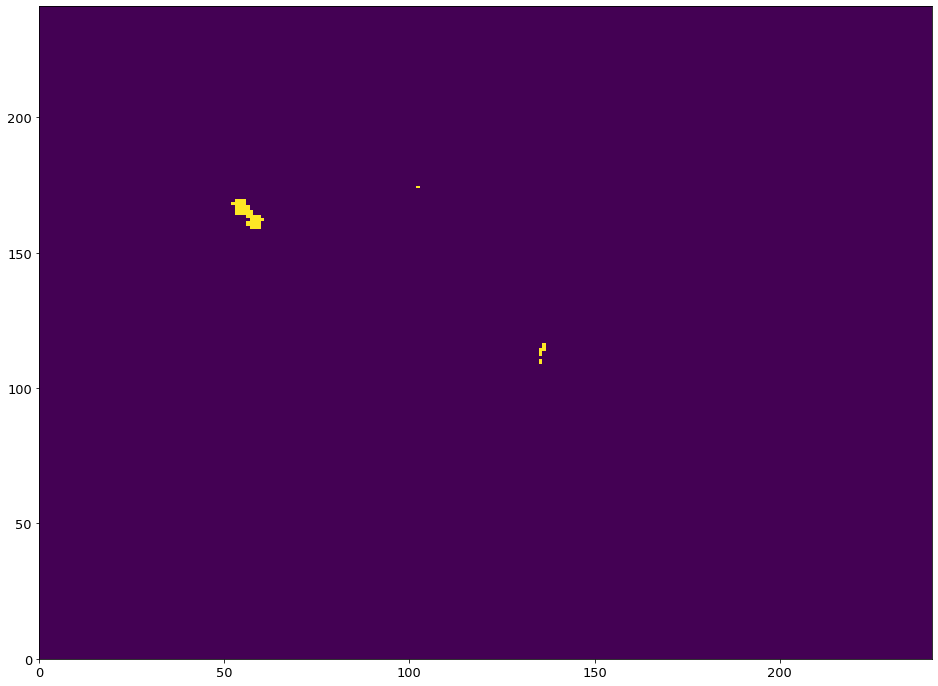

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


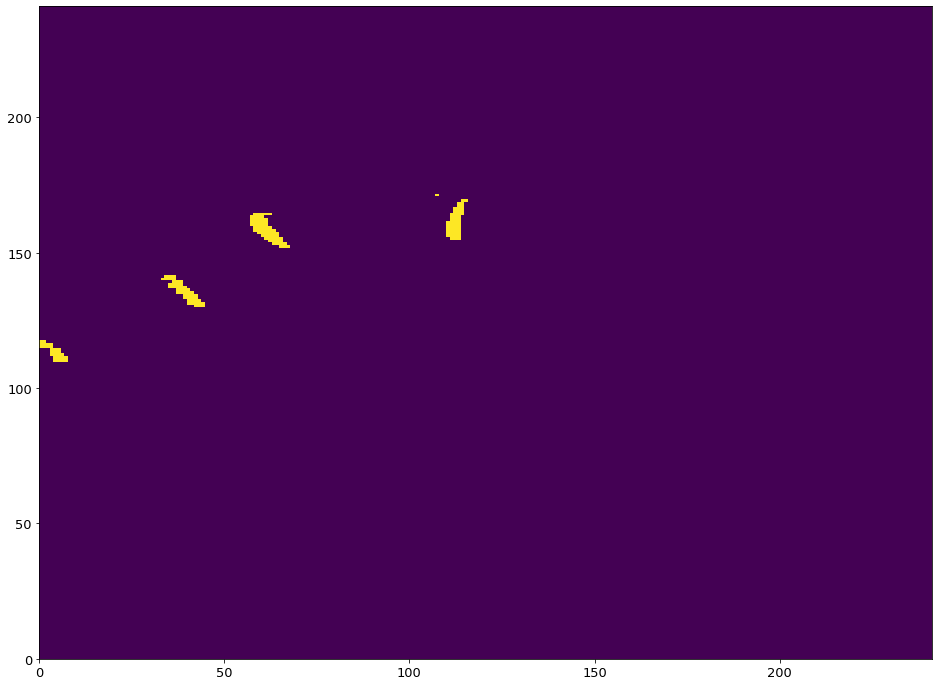

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


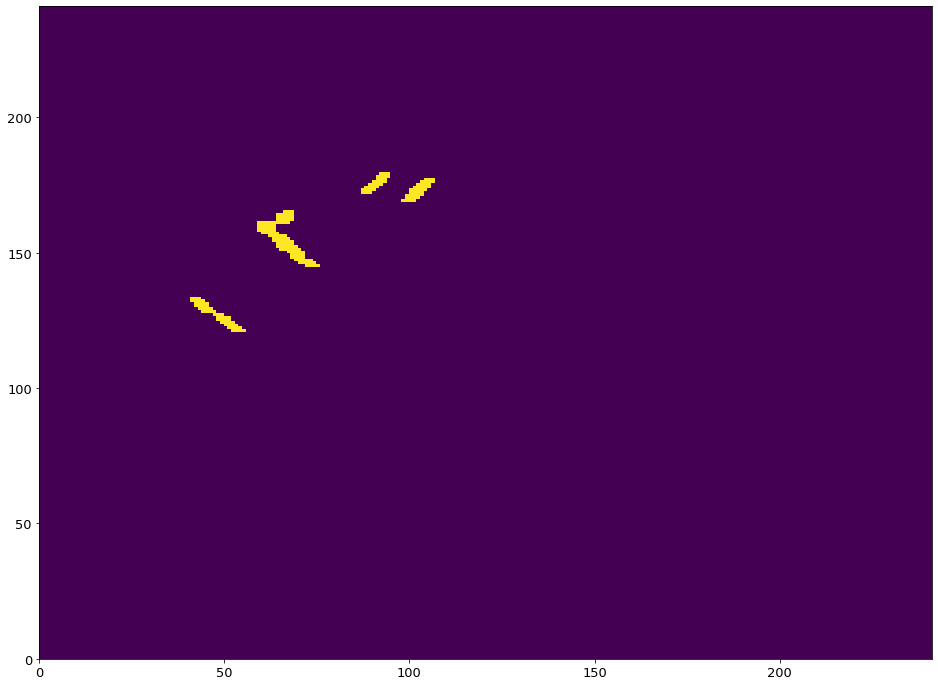

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


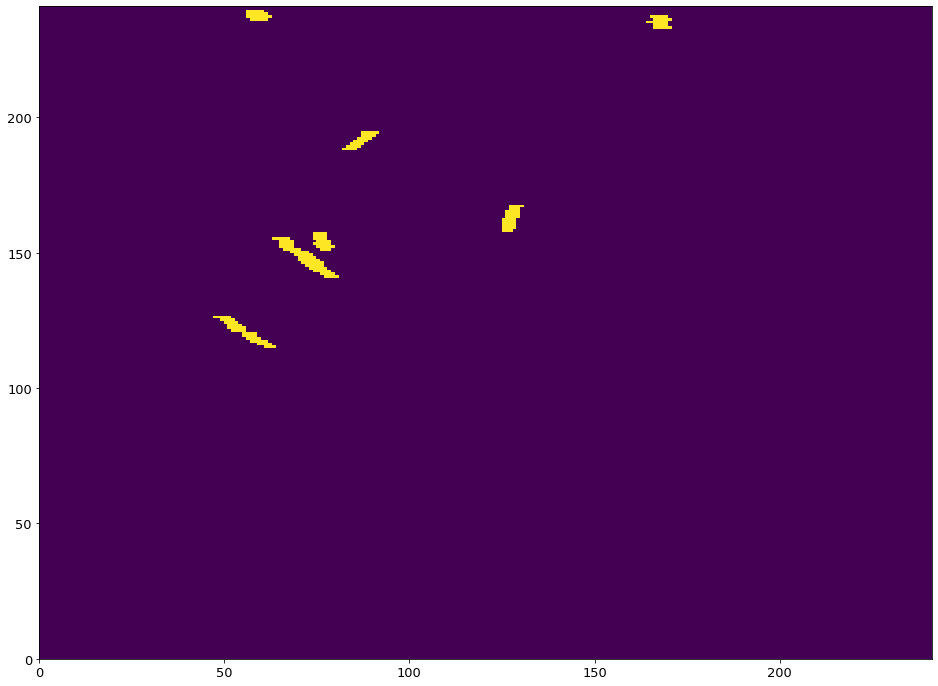

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


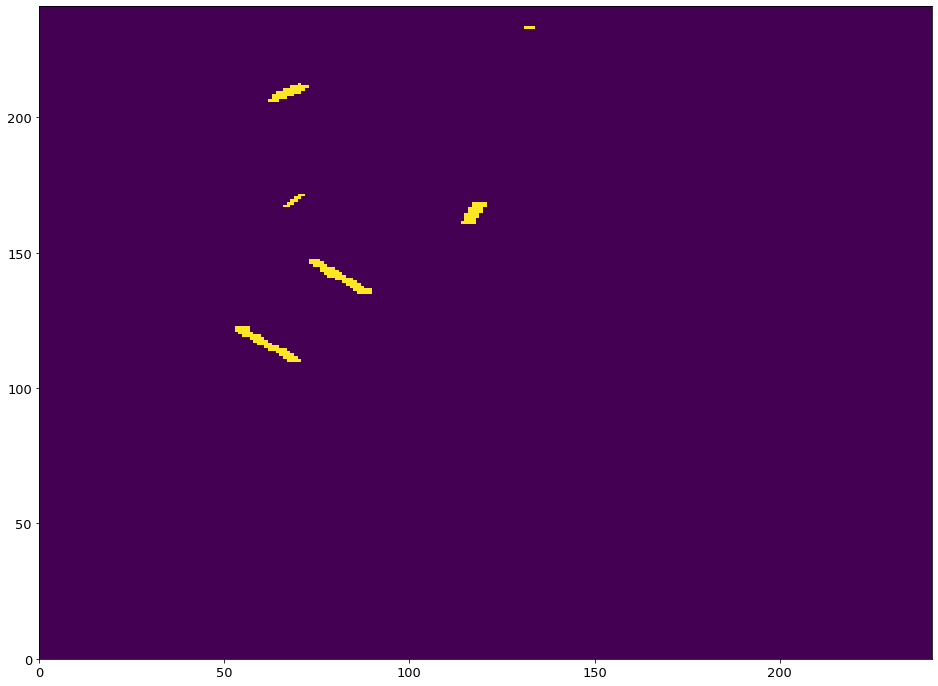

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


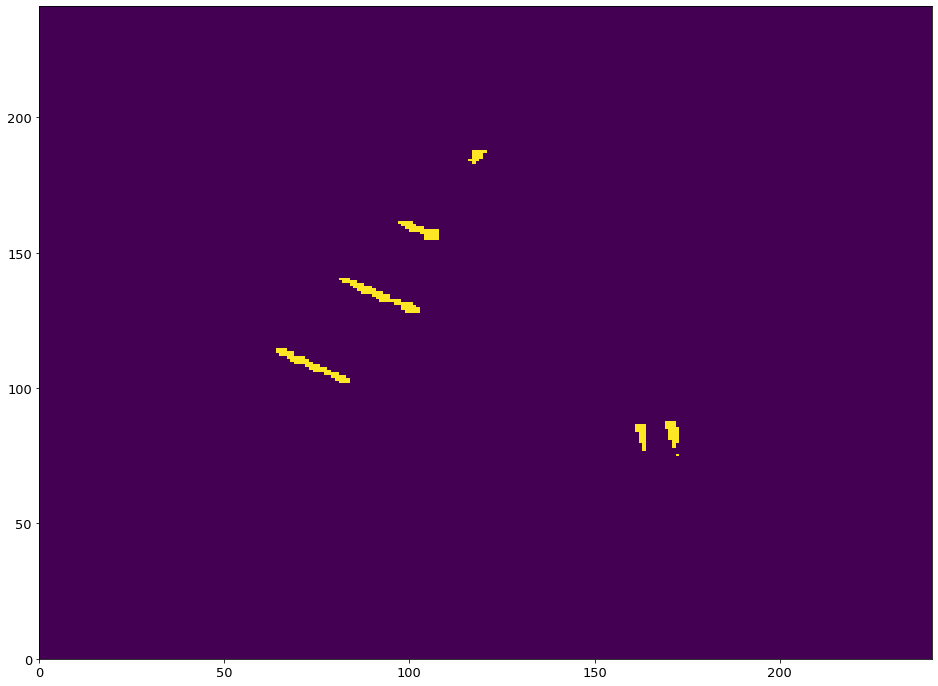

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


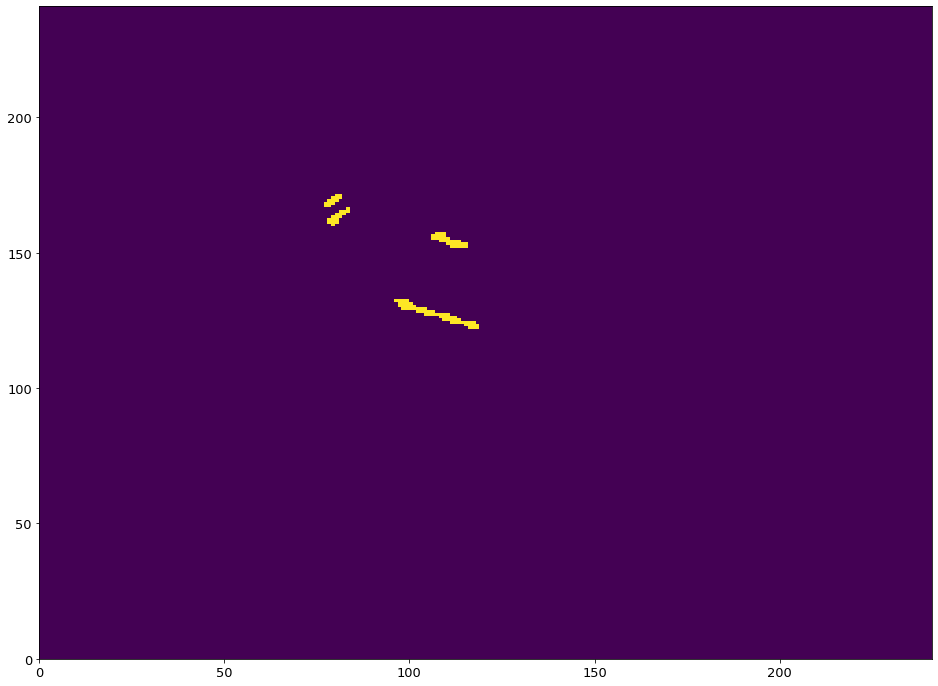

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


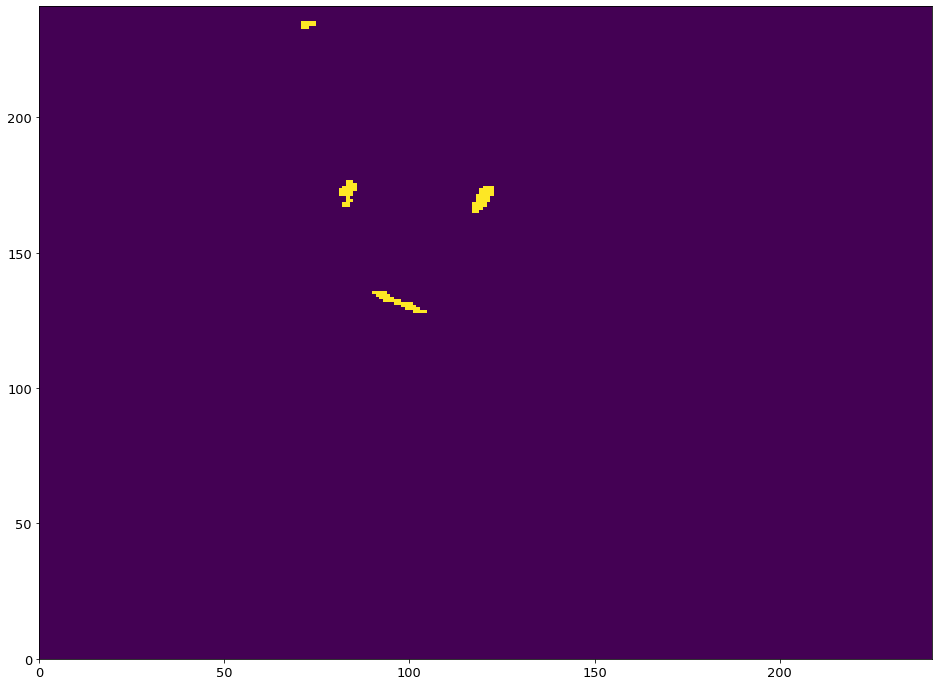

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


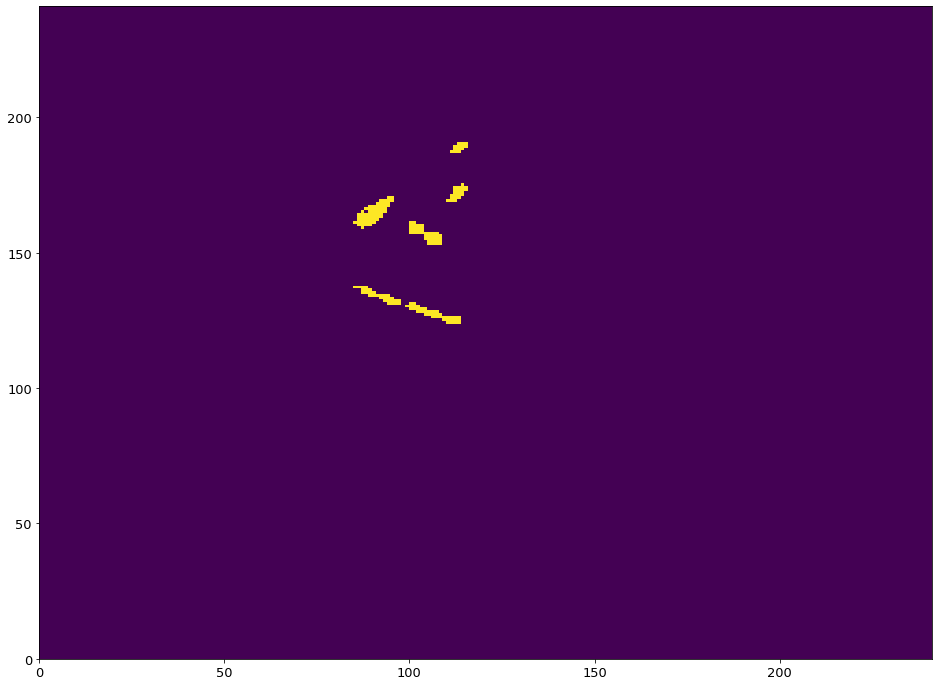

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


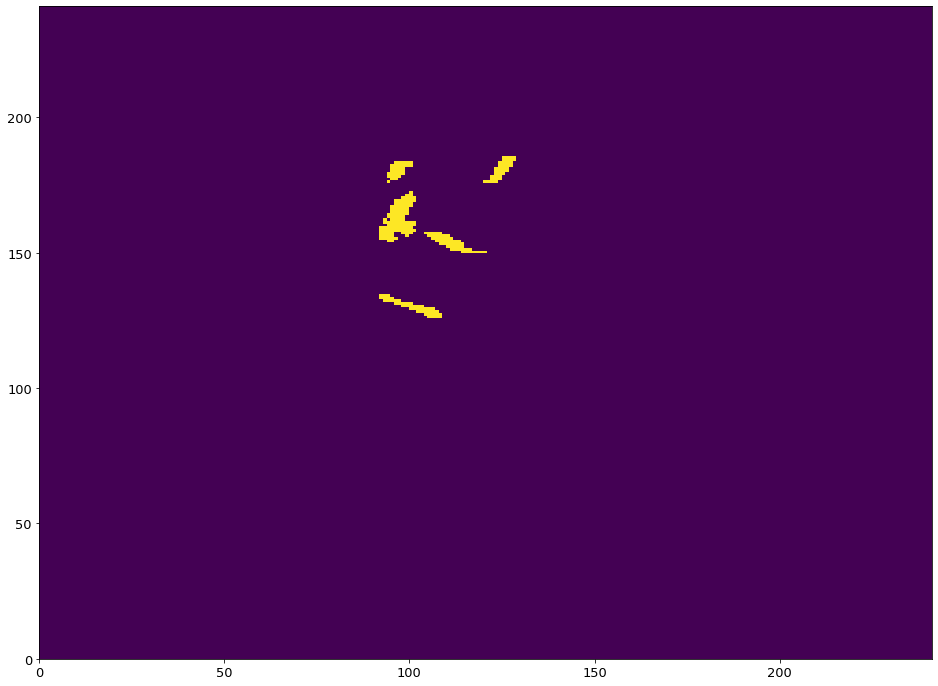

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


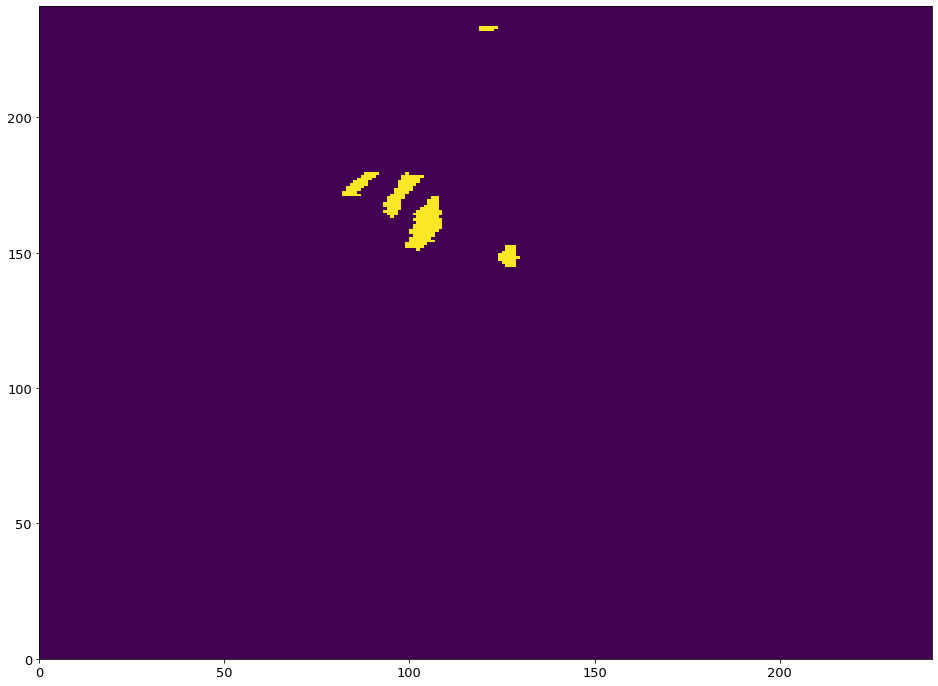

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


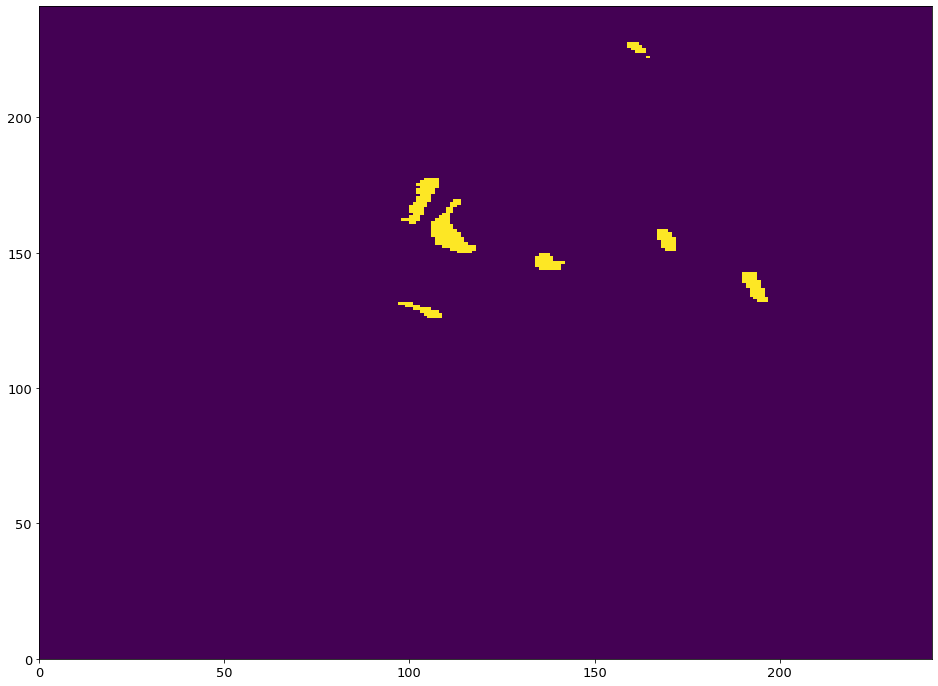

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


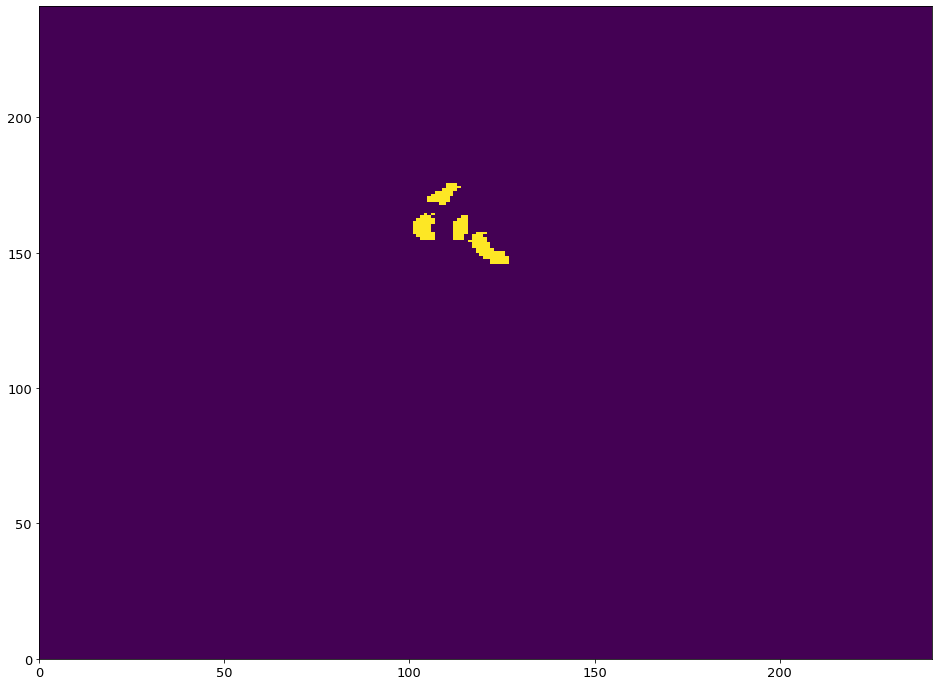

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


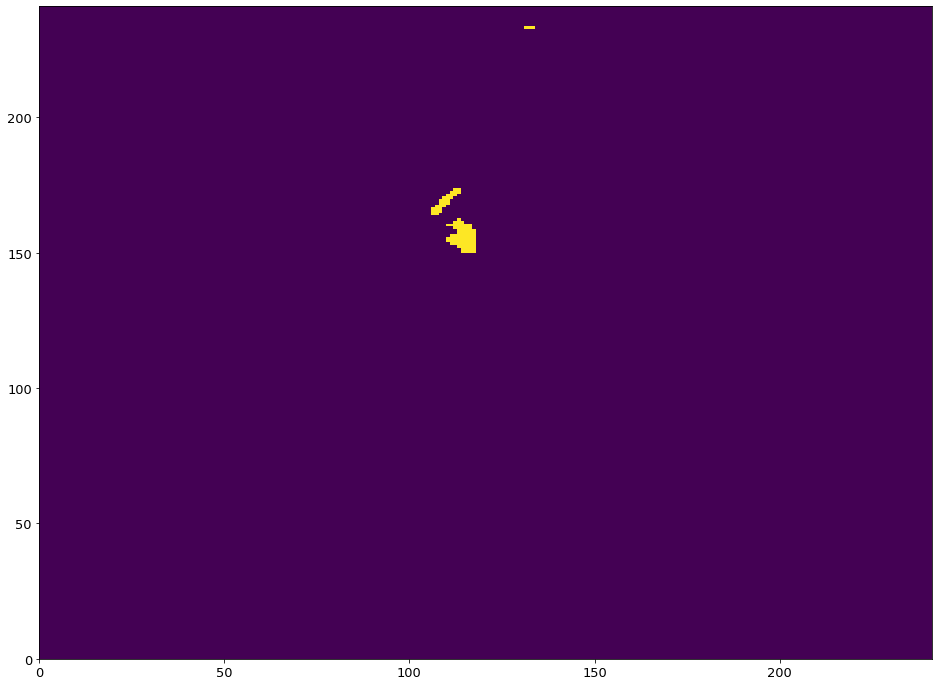

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


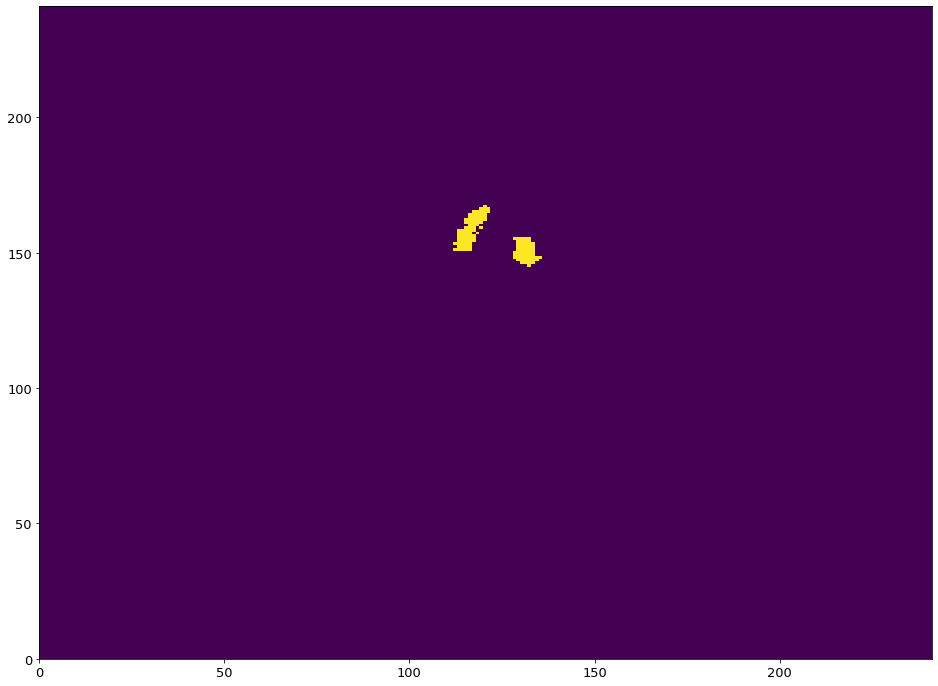

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


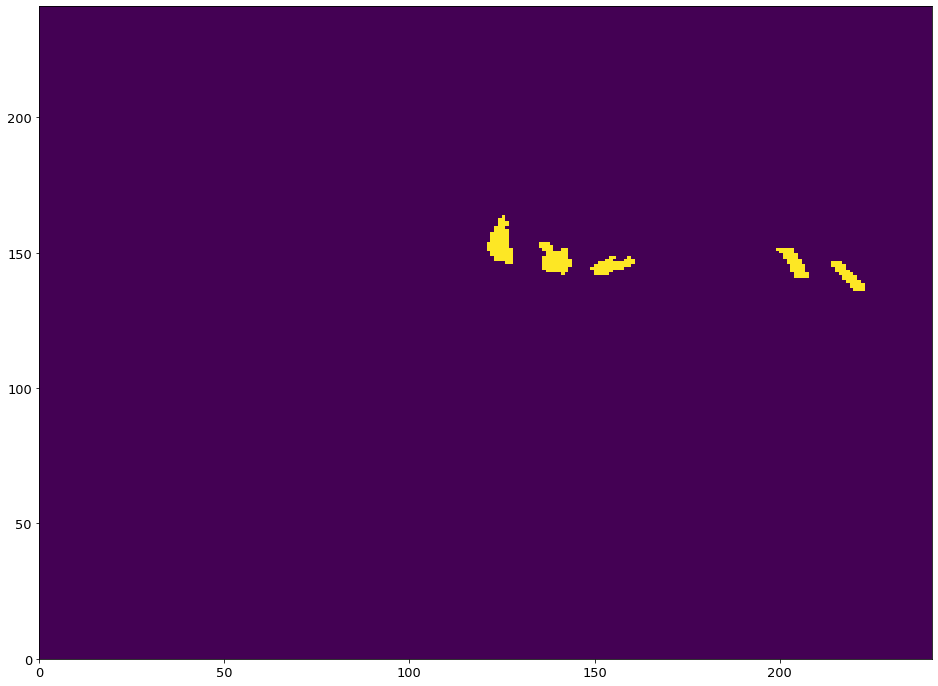

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


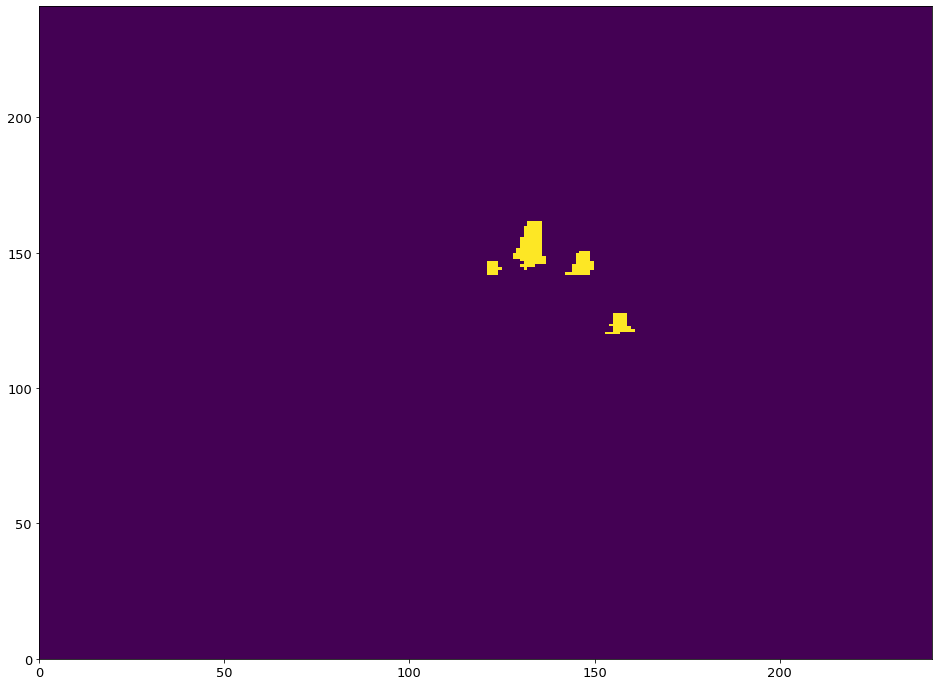

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


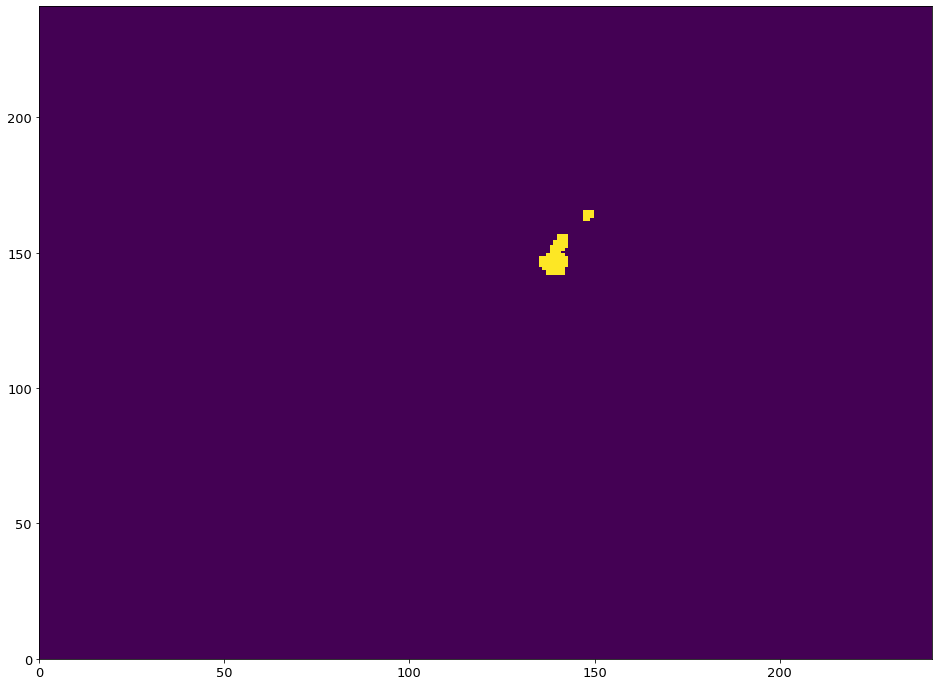

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


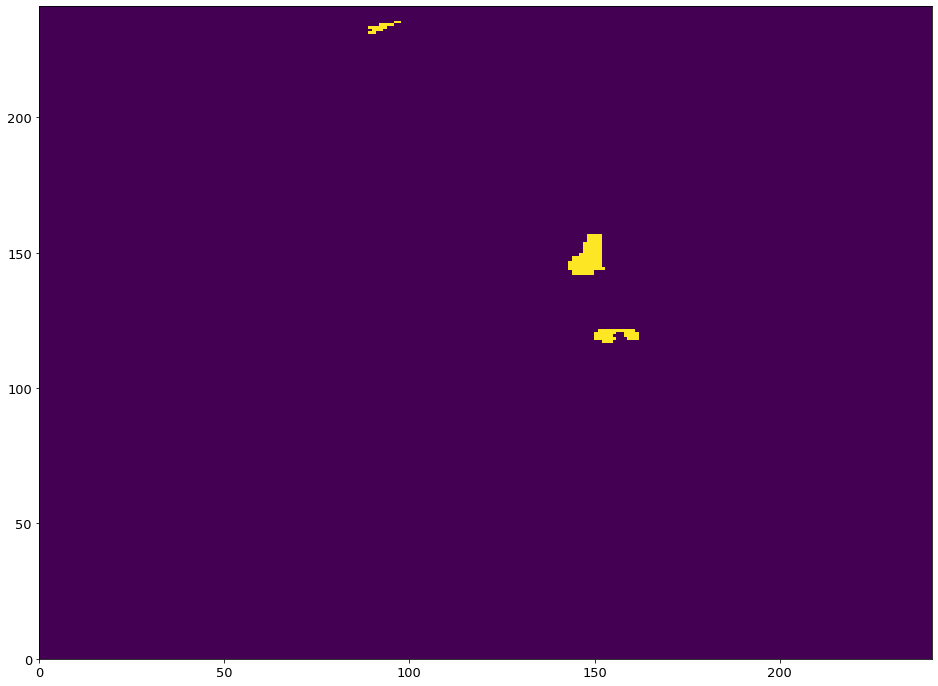

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


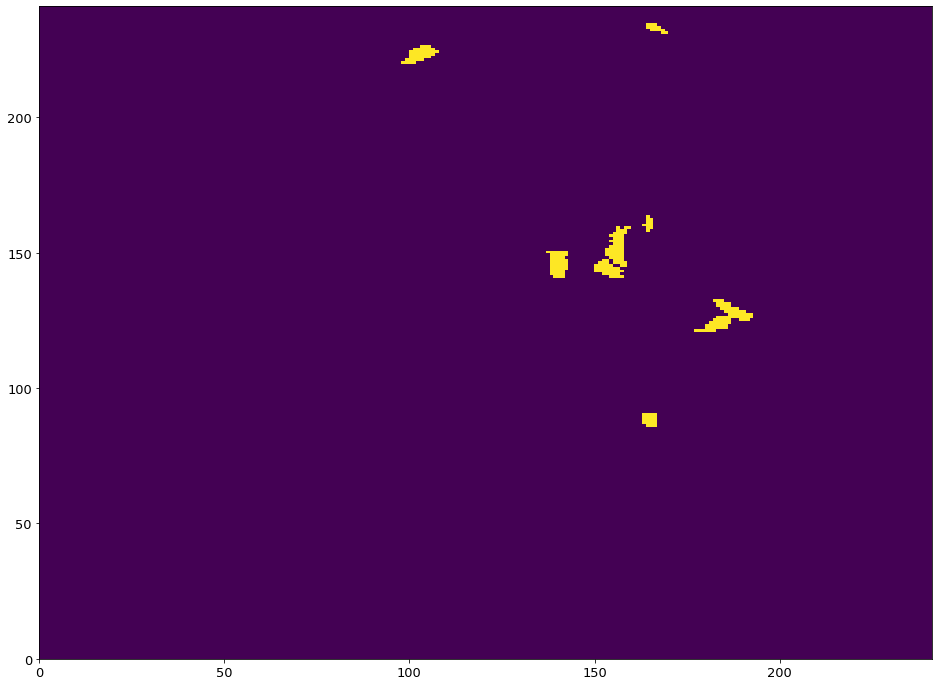

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


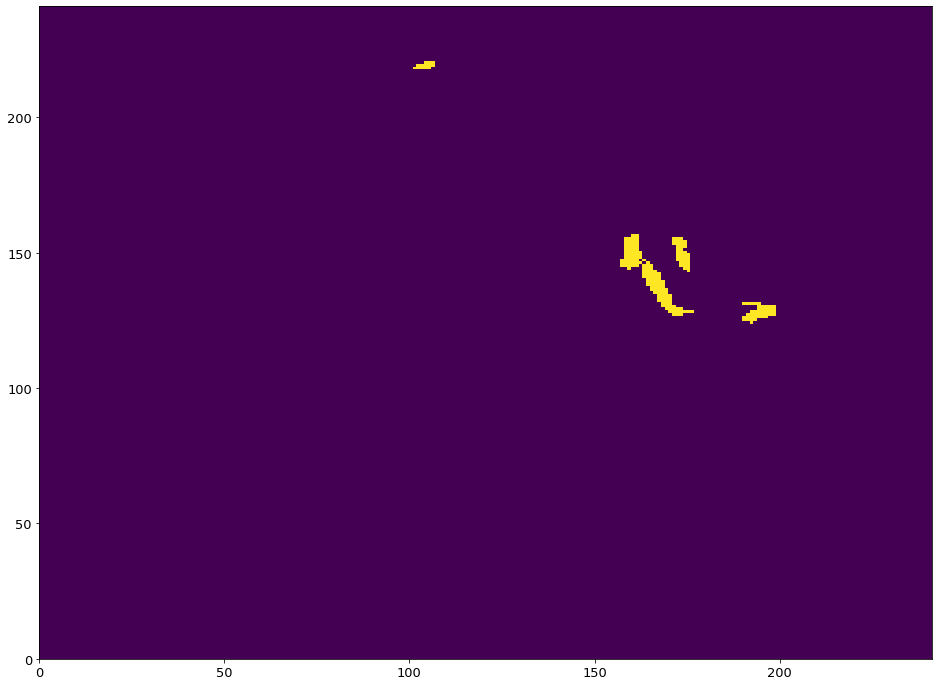

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


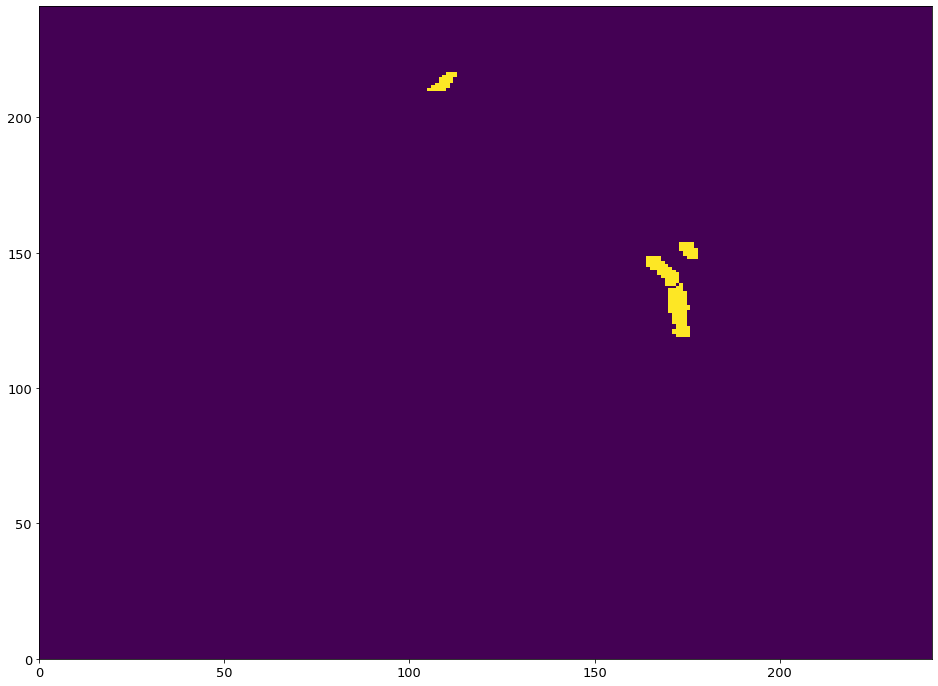

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


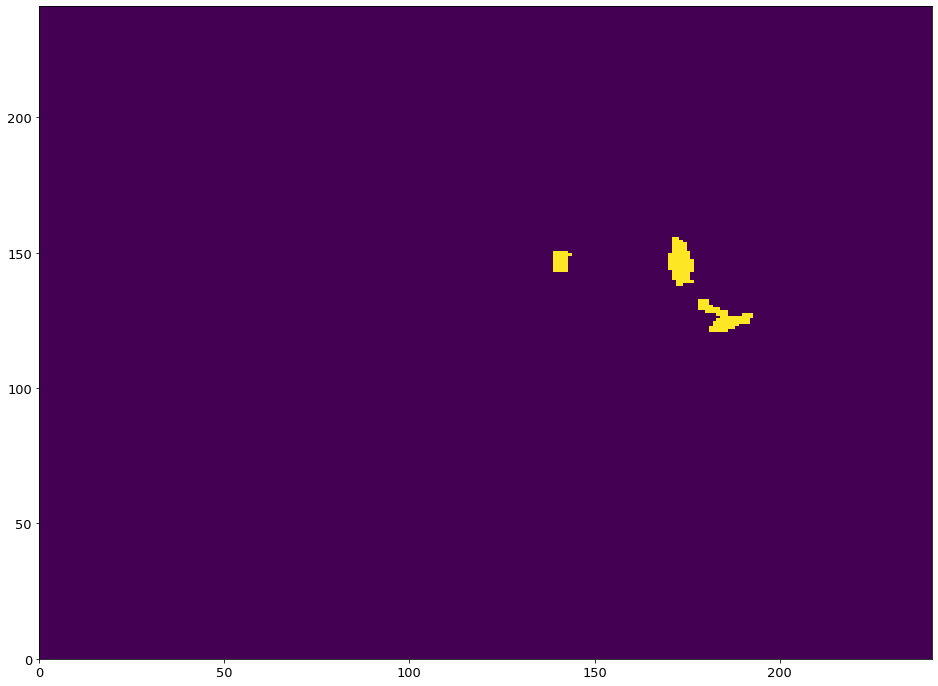

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


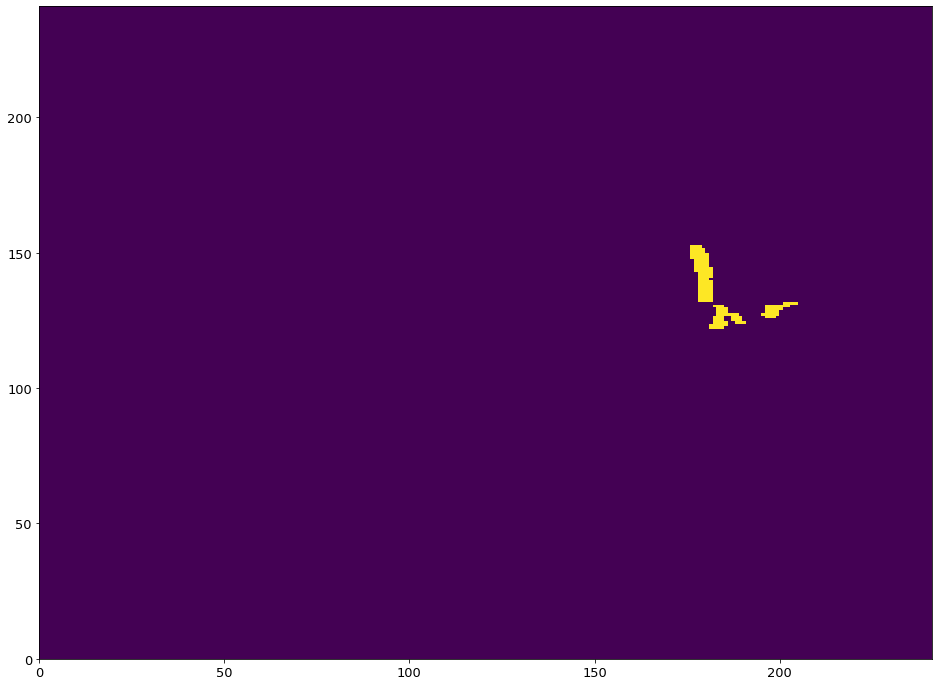

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


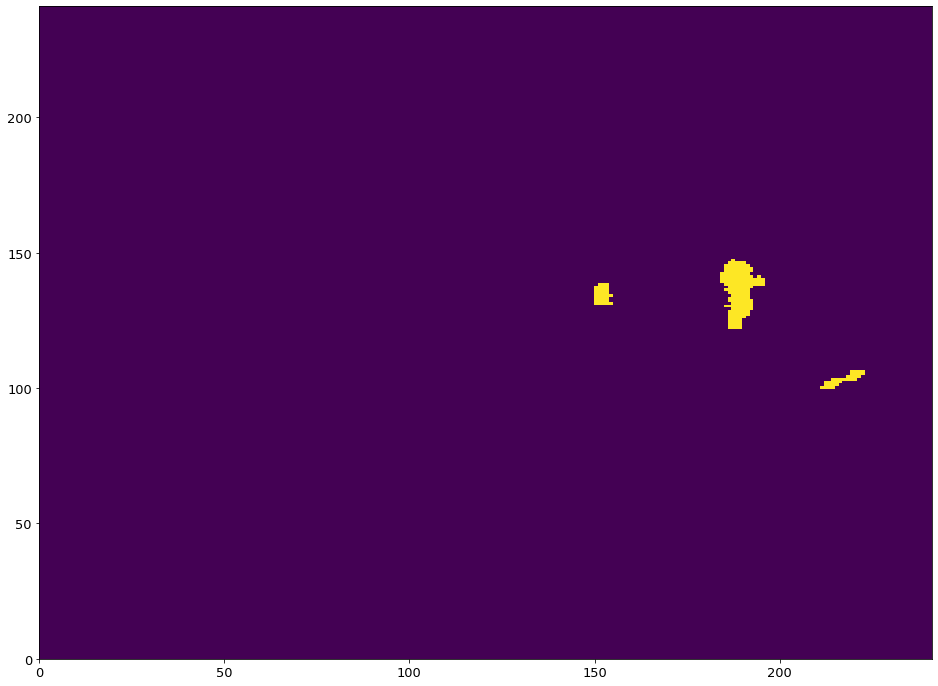

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


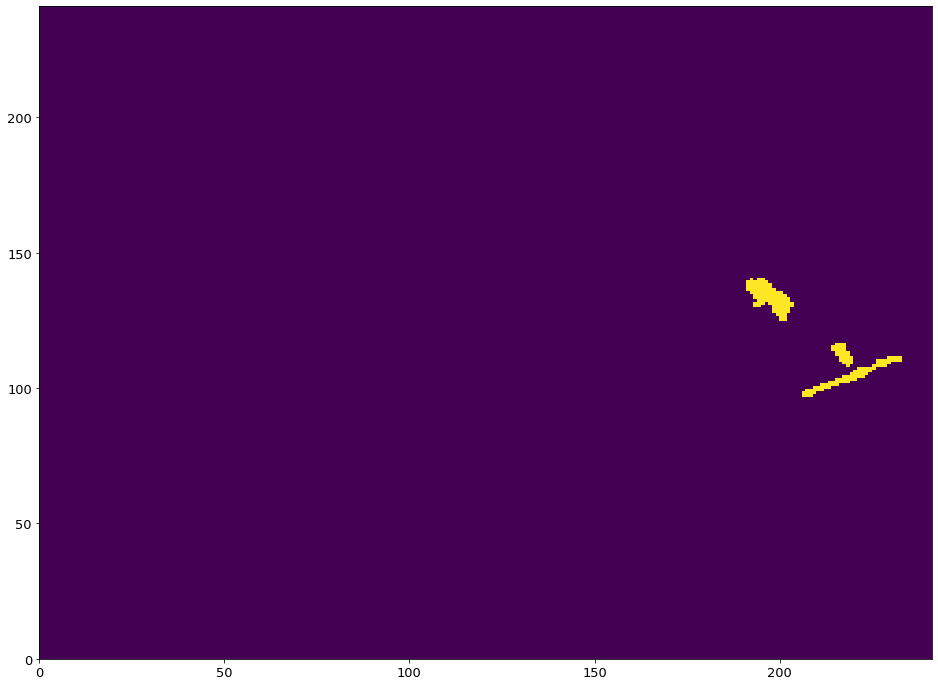

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


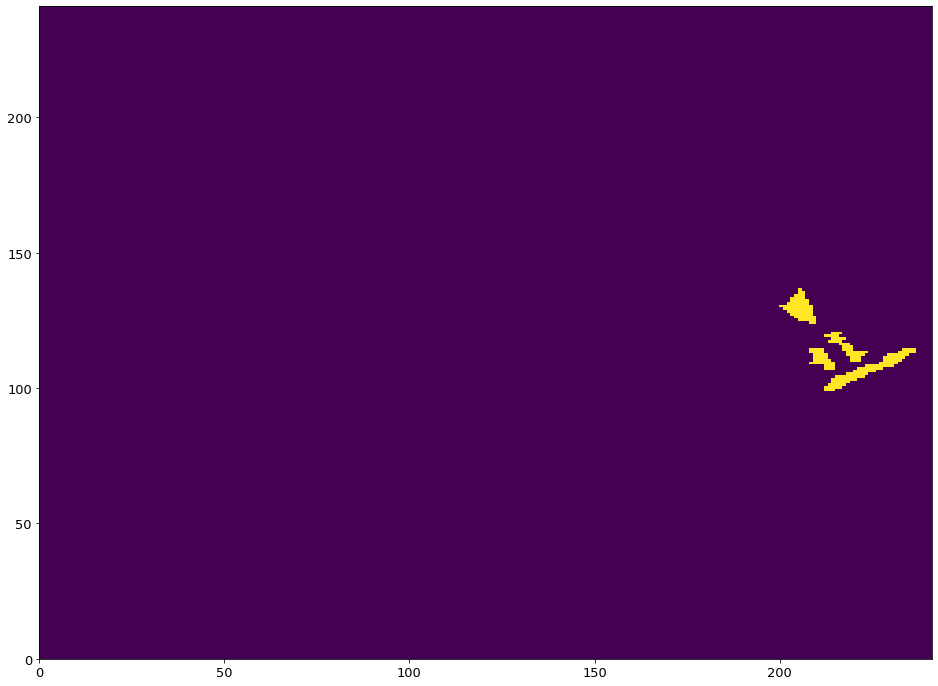

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


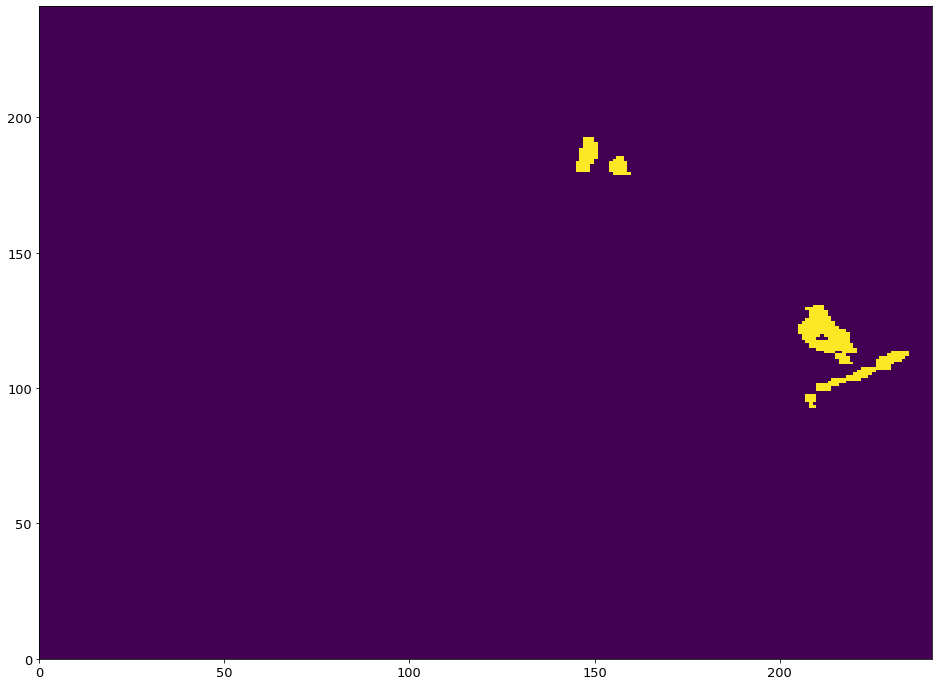

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


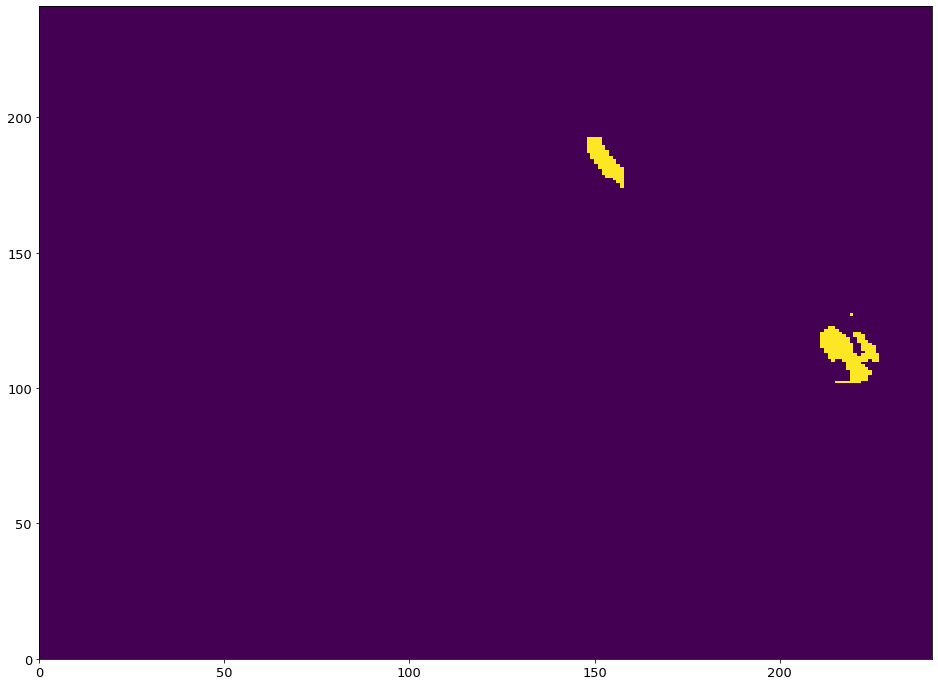

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


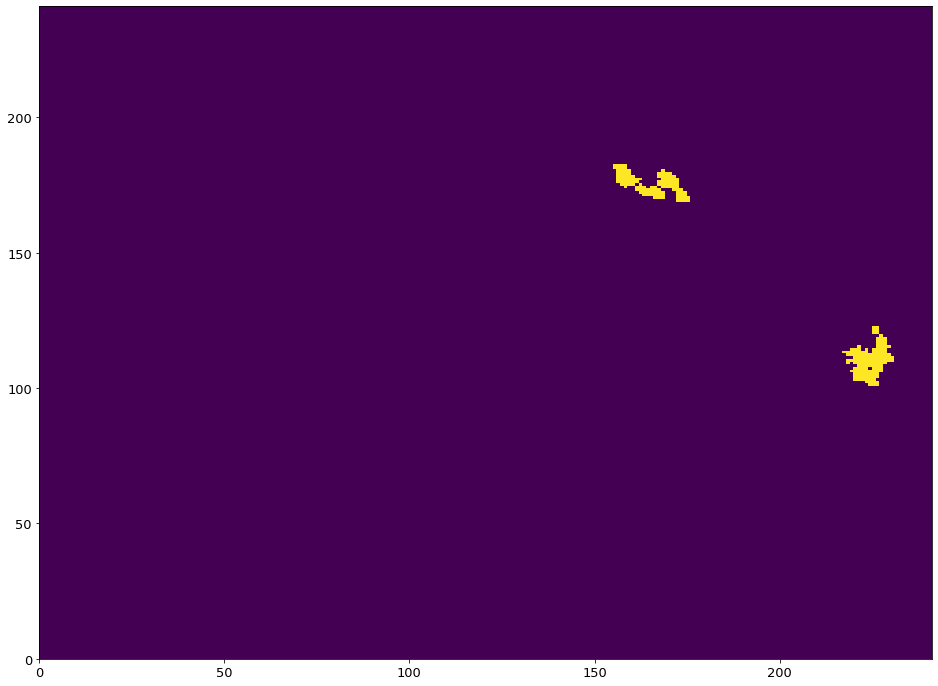

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


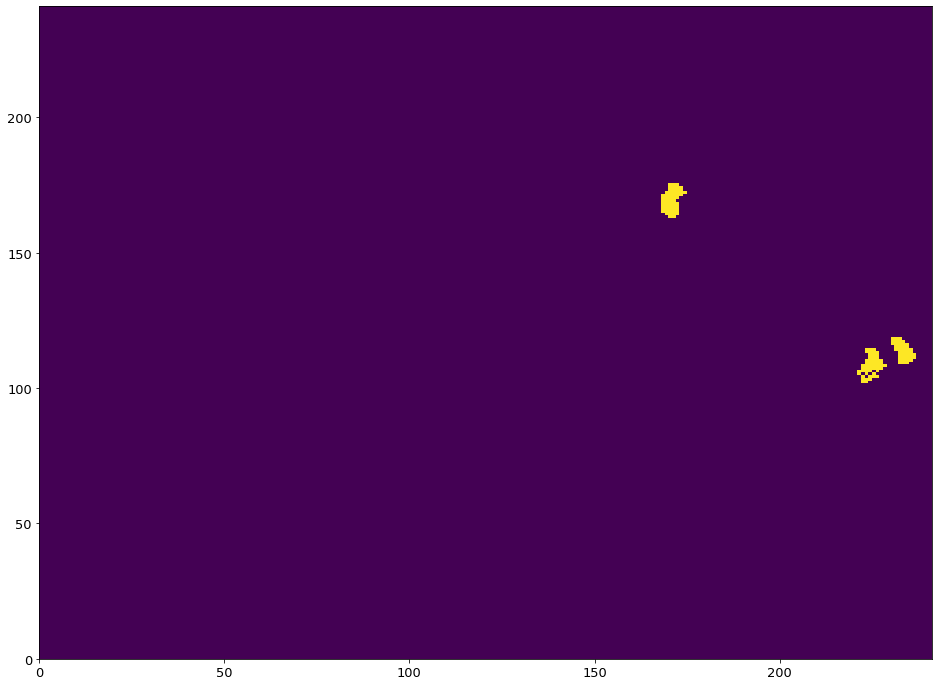

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


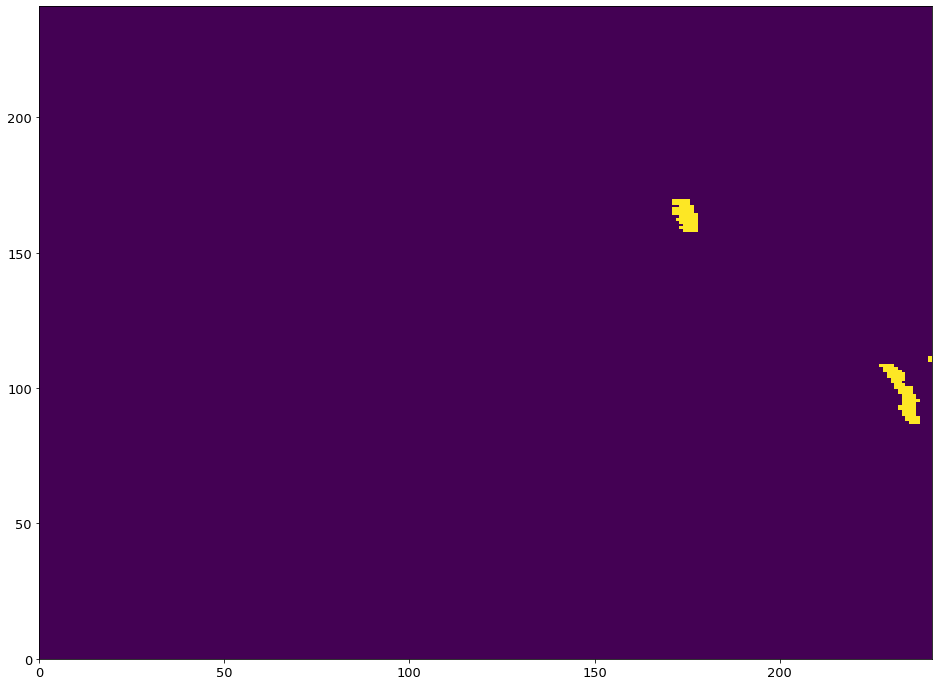

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


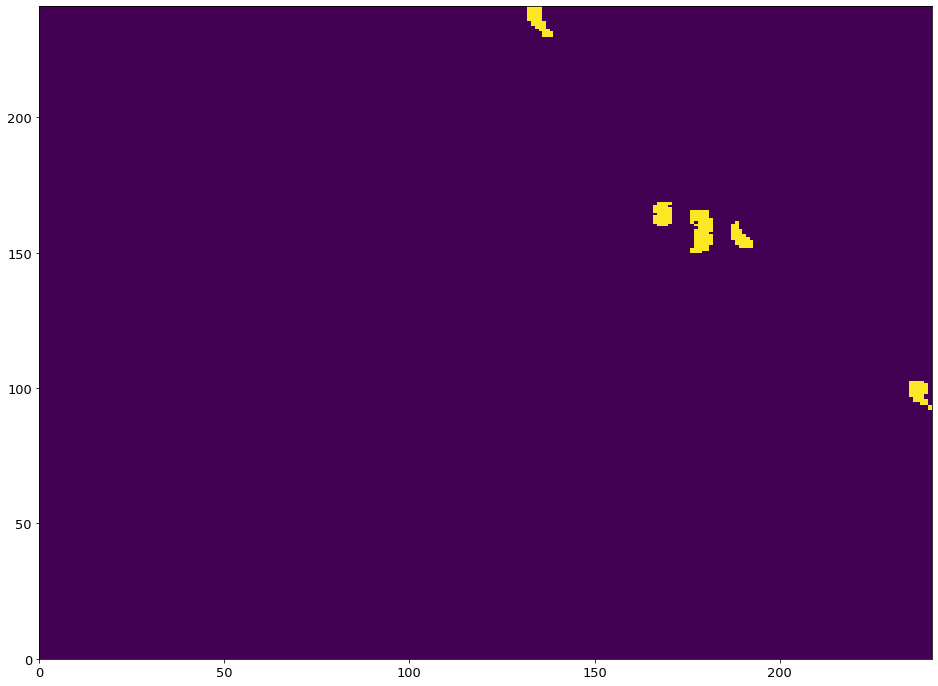

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


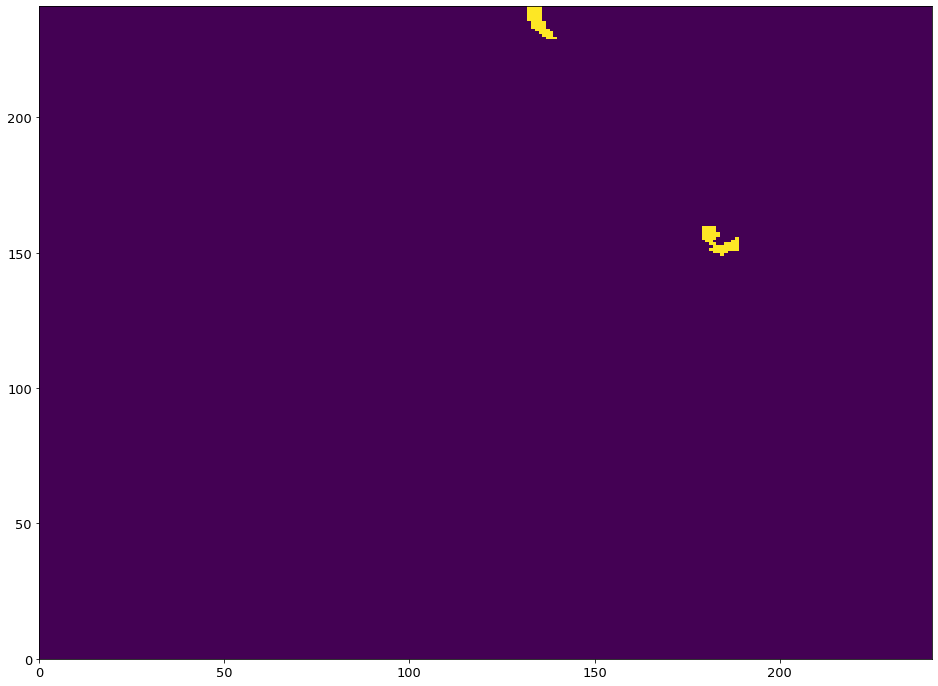

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


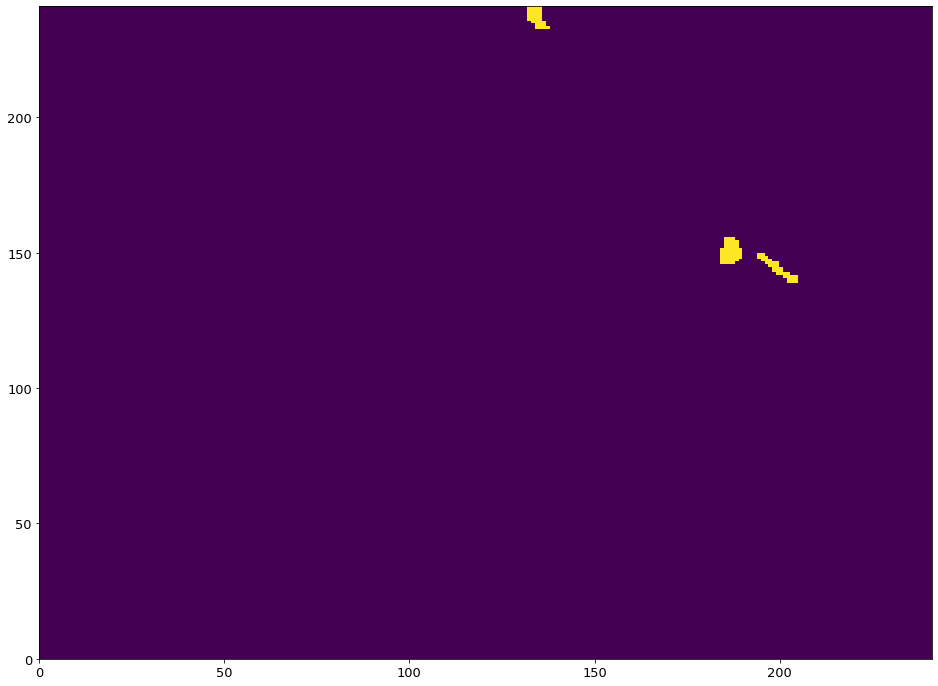

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


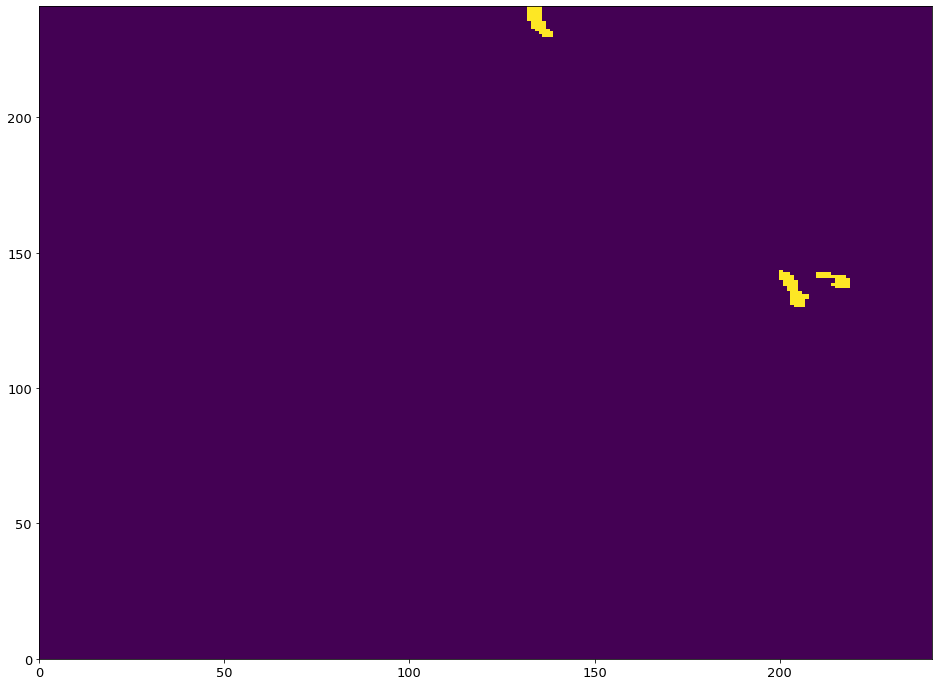

/anaconda3/envs/segmentation/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/ms/Documents/aics-segmentation/aicssegmentation/core/utils.py:128: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


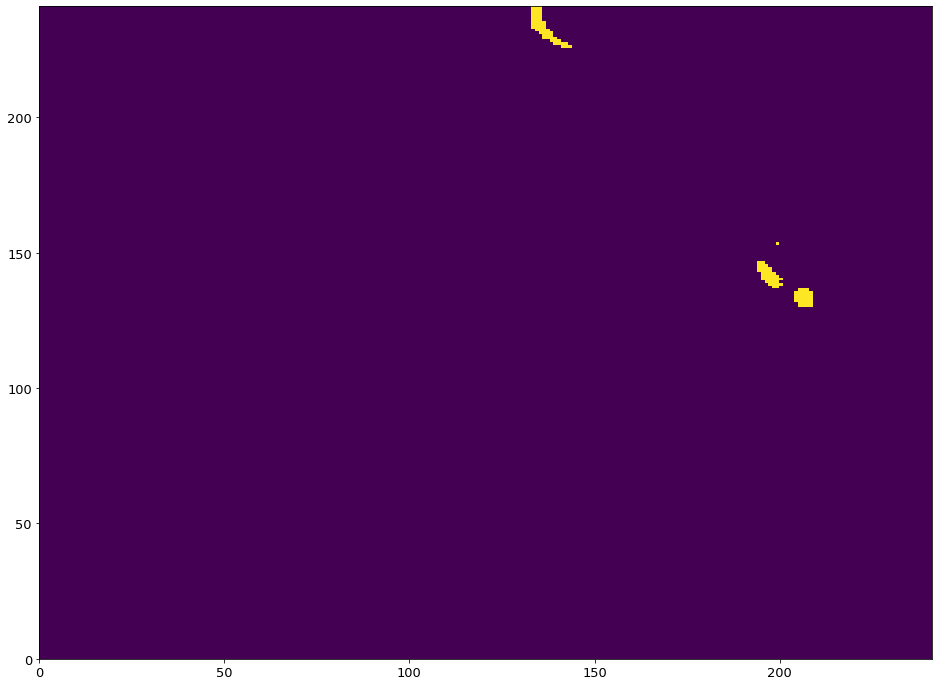

In [102]:
grid_files = sorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc'))
# cfrad_files = sorted(glob.glob('/Users/ms/Desktop/RadxPid_KTLX_May192013/cfradial_files/20130519/*.nc'))
normal = matplotlib.colors.Normalize(vmin=0.75, vmax=4)
cm = matplotlib.cm.ScalarMappable(norm=normal,cmap='cubehelix')

for f in grid_files:

    grid = xr.open_dataset(f)
    arrays = [cm.to_rgba(grid.kdp.where(grid.kdp >= 0.75).squeeze().data[i,:,:]) for i in range(31)]
    zdr_stack = np.stack(arrays)
    zdr_stack = np.interp(zdr_stack, (zdr_stack.min(), zdr_stack.max()), (255, 0))
    zdr_stack = zdr_stack[8:23]
    
    reader = AICSImage(zdr_stack,dims="ZYXC")
    IMG = reader.data
    struct_img0 = IMG[0,:,:,1,:].copy()
    
    ################################
    intensity_scaling_param = [52,0]
    gaussian_smoothing_sigma = 1
    ################################

#     # intensity normalization
#     low_ratio,up_ratio = suggest_normalization_param_custom(struct_img0)

#     while ((low_ratio != intensity_scaling_param[0]) or (up_ratio != intensity_scaling_param[1])): 
#         struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
#         low_ratio,up_ratio = suggest_normalization_param_custom(struct_img0)

    # smoothing with gaussian filter
    structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img0, sigma=gaussian_smoothing_sigma)
    
    #     s2_param = [[1.25,0.9],[1,0.07],[1,0.01],[1.5,0.005]]
    s2_param = [[1.25,0.05],[1.15,0.9]]

    fill_2d = True
    fill_max_size = 100000
    
    ################################

    bw_spot = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)
#     bw_spot_fill = hole_filling(bw_spot, 80, fill_max_size, fill_2d)
    
    ################################
    ## PARAMETERS for this step ##
#     f2_param = [[1.25, 0.07],[1.25,0.05]]
    f2_param = [[1.25, 0.07],[1.25,0.05]]
    fill_2d = True
    fill_max_size = 100000
    ################################

    bw_filament = filament_2d_wrapper(structure_img_smooth, f2_param)
#     bw_filament_fill = hole_filling(bw_filament, 100, fill_max_size, fill_2d)
    
    bw = np.logical_or(bw_spot, bw_filament)
    bw_fill = hole_filling(bw, 200, fill_max_size, fill_2d)
    bw_fill = np.invert(bw_fill)


    # watershed
    minArea = 50
    Mask = remove_small_objects(bw_fill>0, min_size=minArea, connectivity=1, in_place=False) 
    Seed = dilation(peak_local_max(struct_img0,labels=label(Mask), min_distance=1, indices=False), selem=ball(1))
    Watershed_Map = -1*distance_transform_edt(bw_fill)
    seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)
    
    ################################
    ## PARAMETERS for this step ##
    minArea = 50                     
    ################################
    
    
    seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)
#     seg = np.ma.masked_where(mask==False,seg)
#     np.ma.set_fill_value(seg,-999)
    
    seg  = np.swapaxes(seg,0,2)
    seg = np.invert(seg)
    seg = seg >0
    out=seg.astype(np.uint8)
    out = 1 - out
    out[out>0]=255
    out = np.rot90(out[:,:,:],axes=[1,2])

    # plt.pcolormesh(out[0,:,:])
    fsave_name = f.split('/')[-1][21:27]
    
    plt.pcolormesh(out[0,:,:])
    plt.show()
    
    writer = omeTifWriter.OmeTifWriter(f'/Users/ms/Desktop/kdp_direct_segmentation_new/{fsave_name}.tiff')
    writer.save(out)

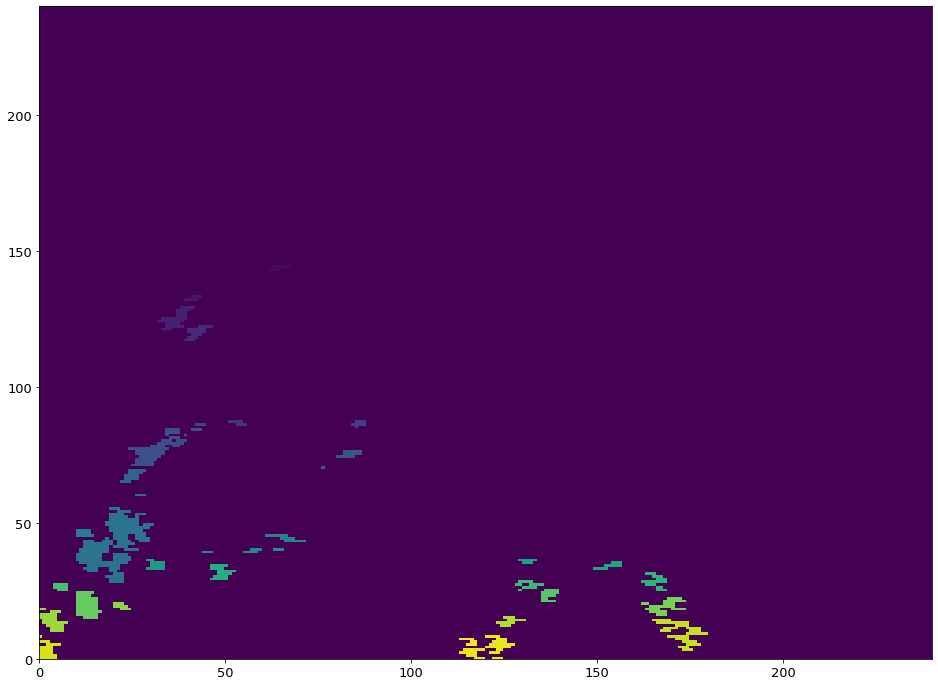

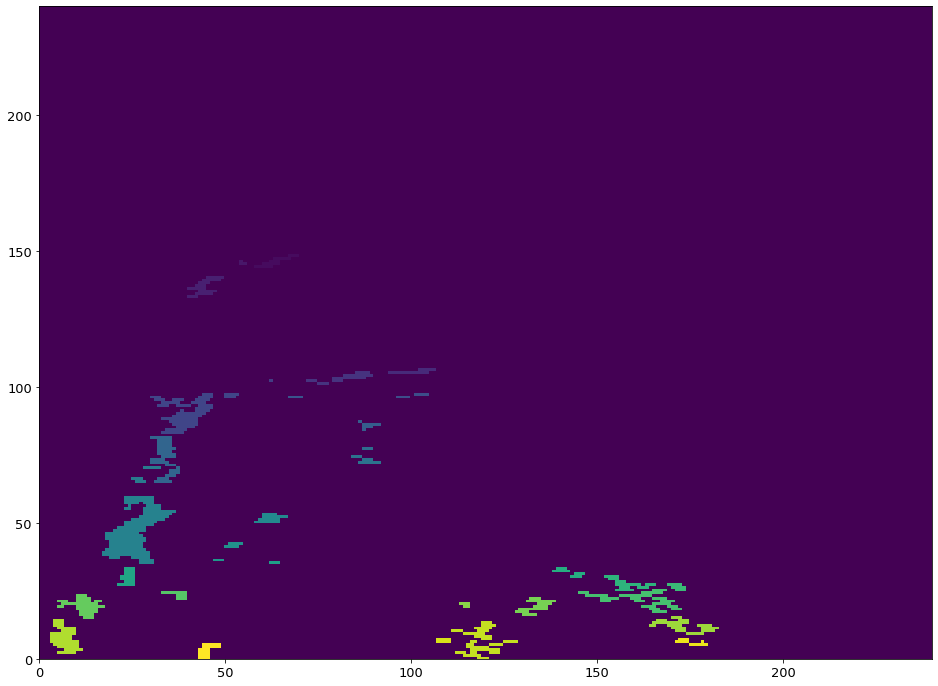

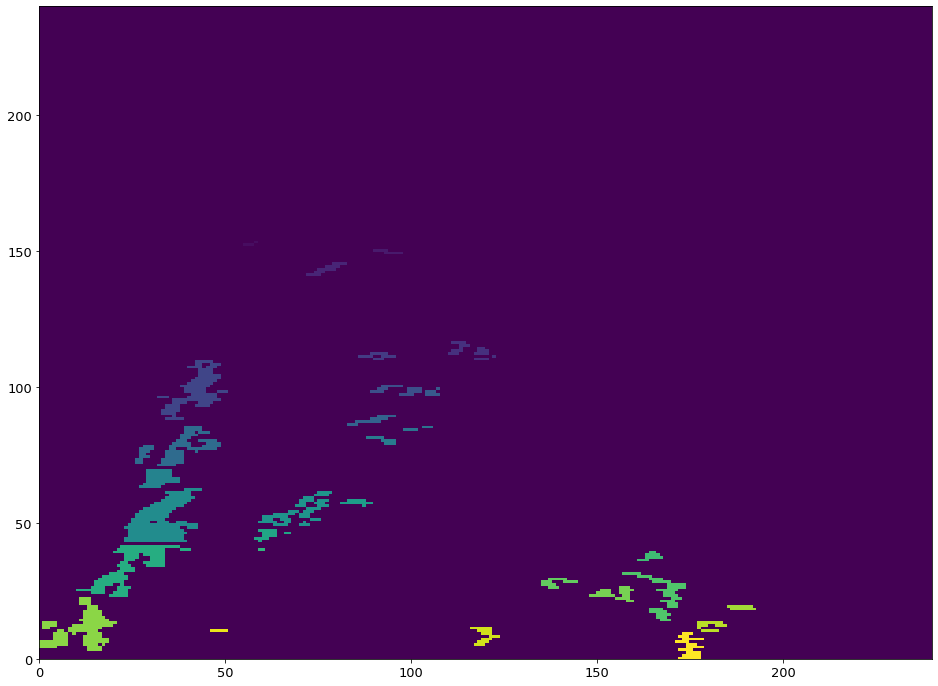

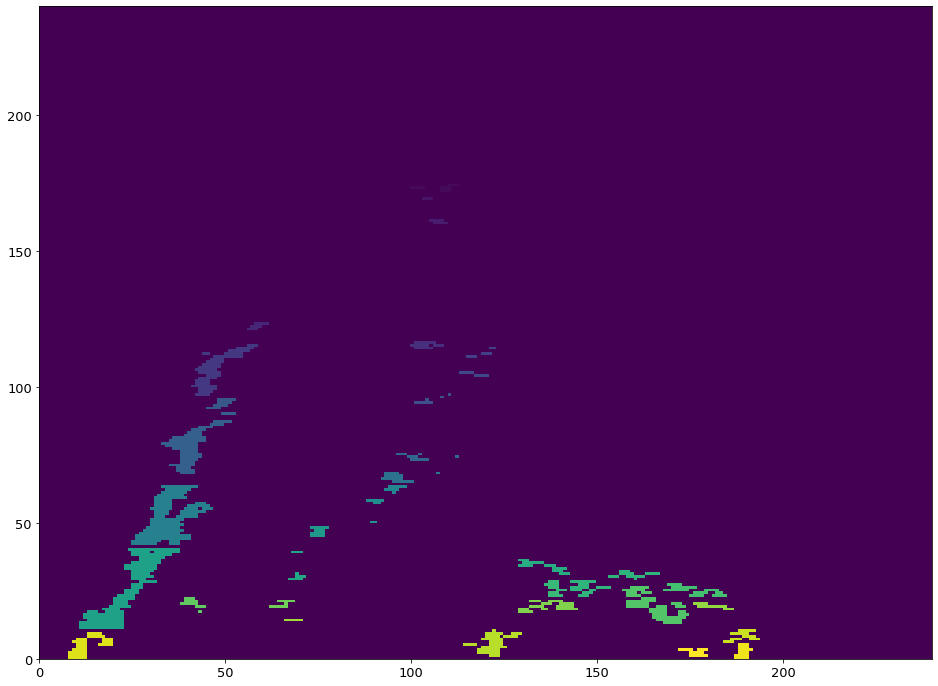

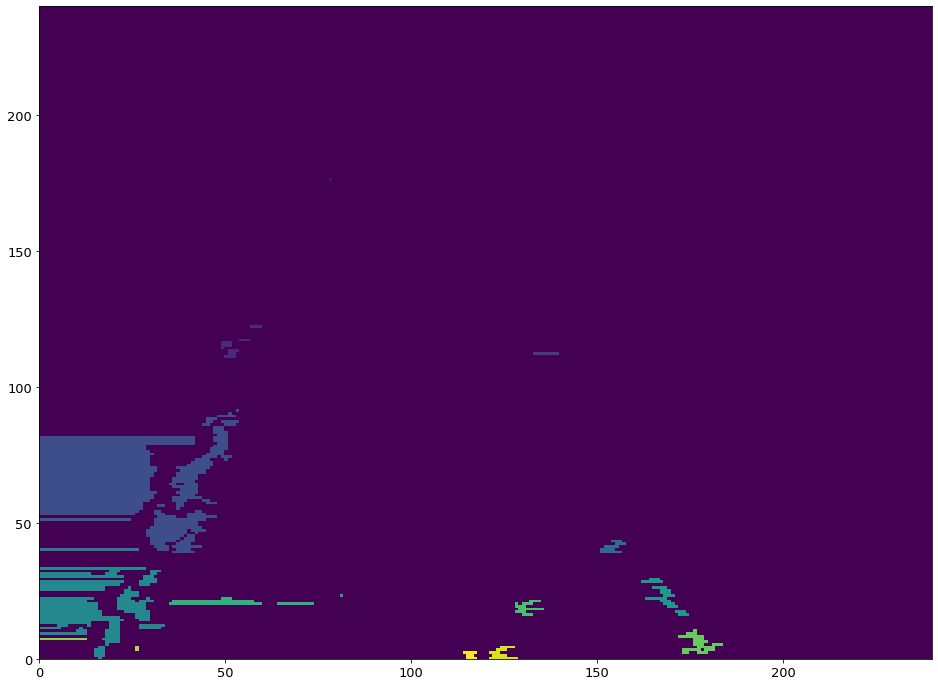

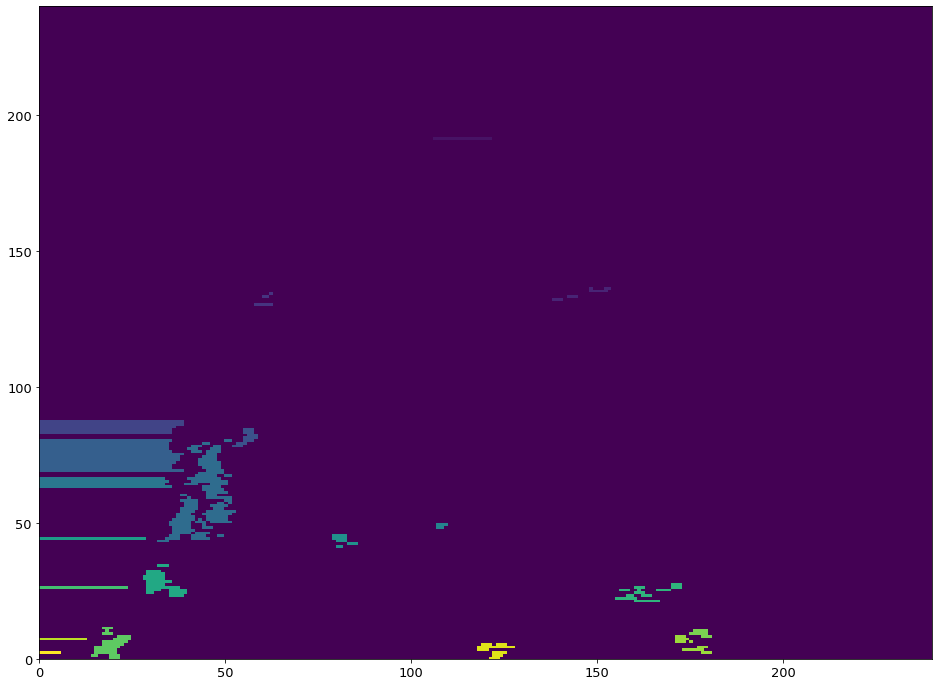

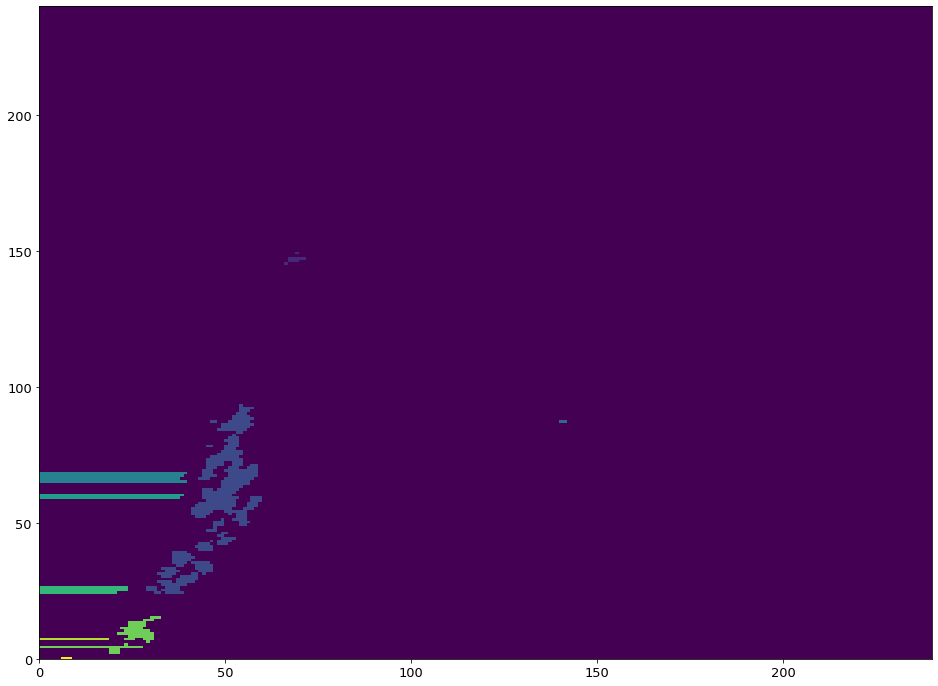

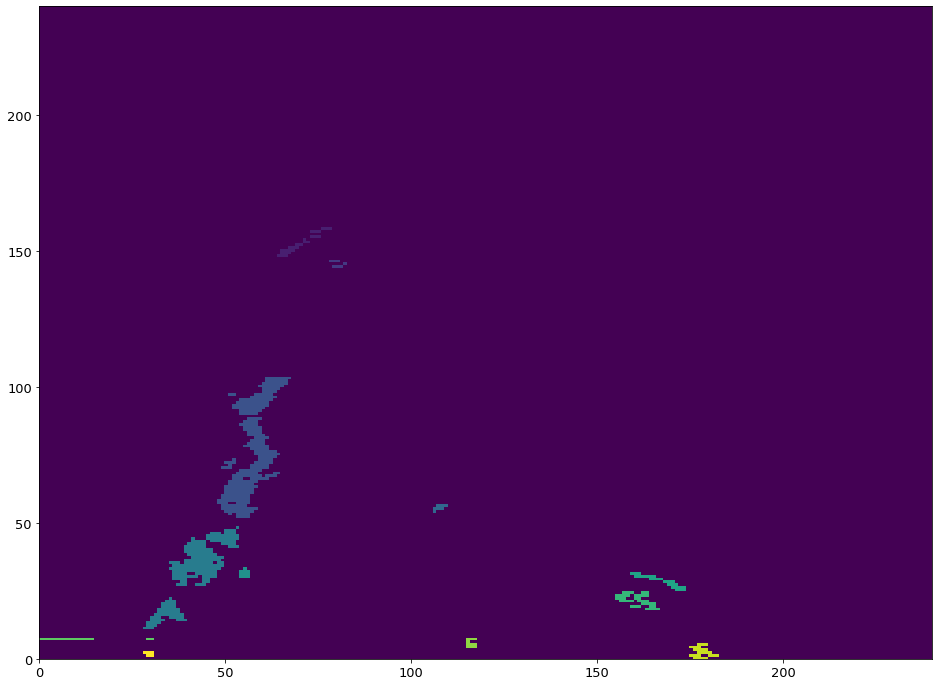

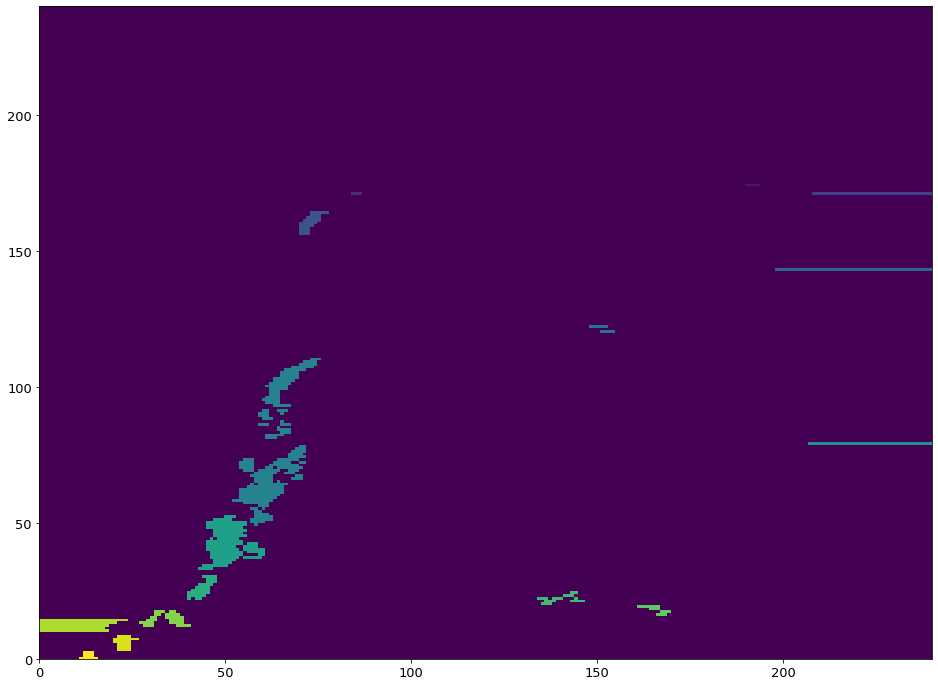

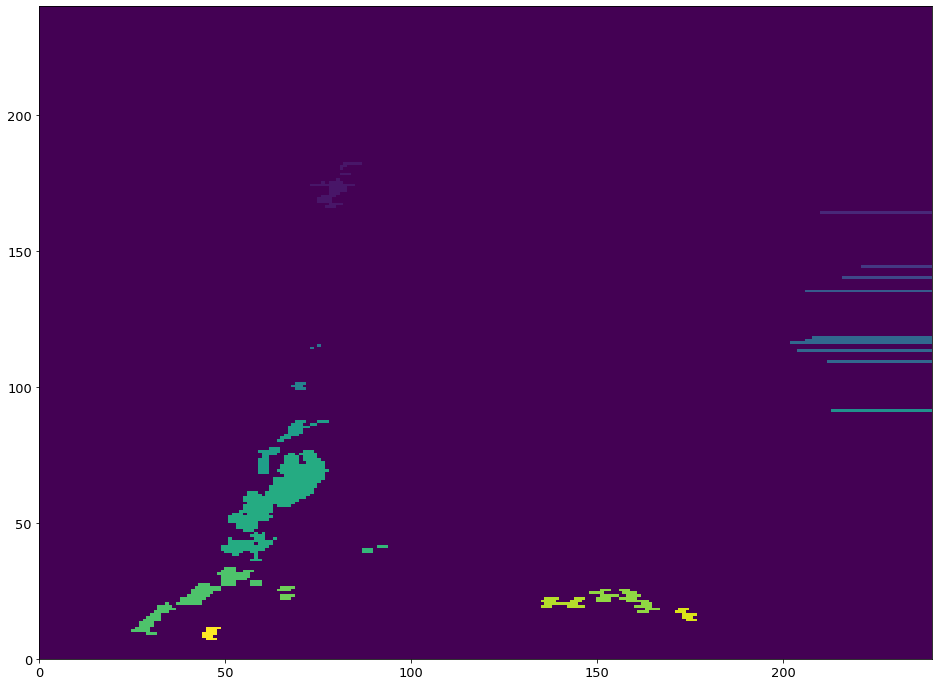

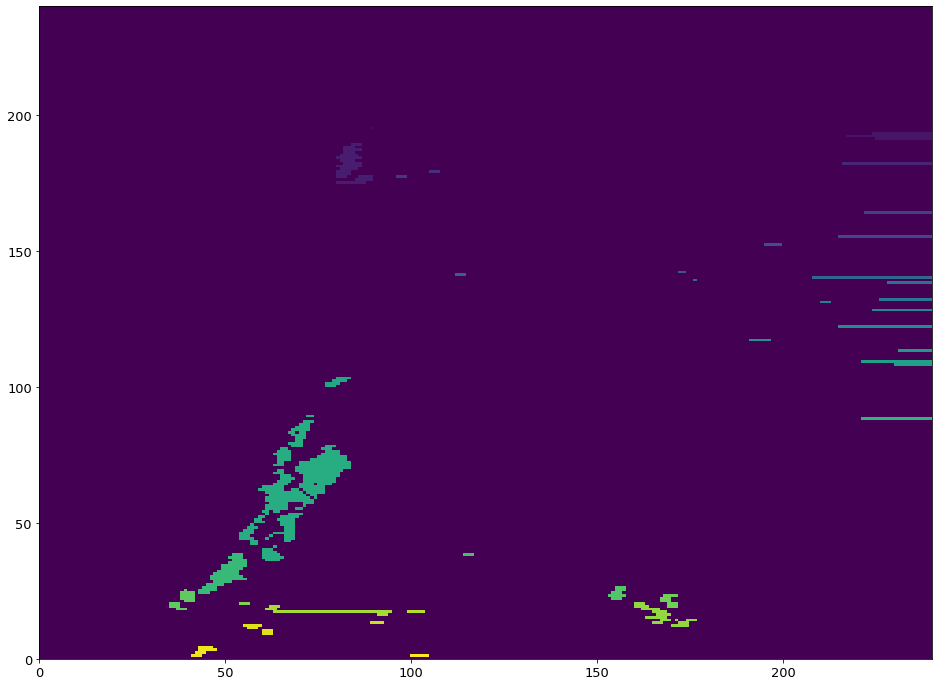

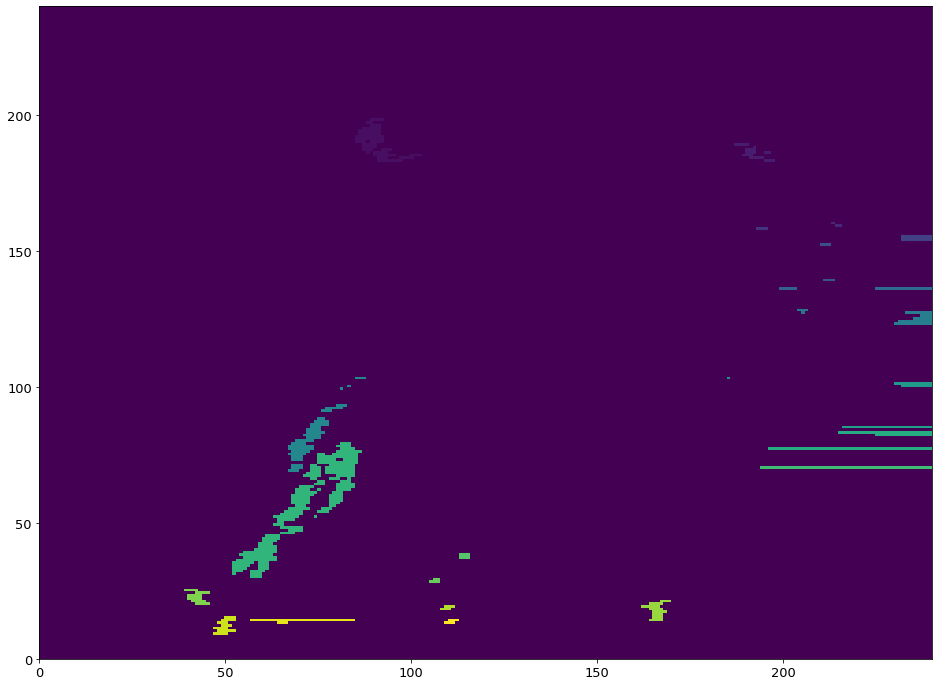

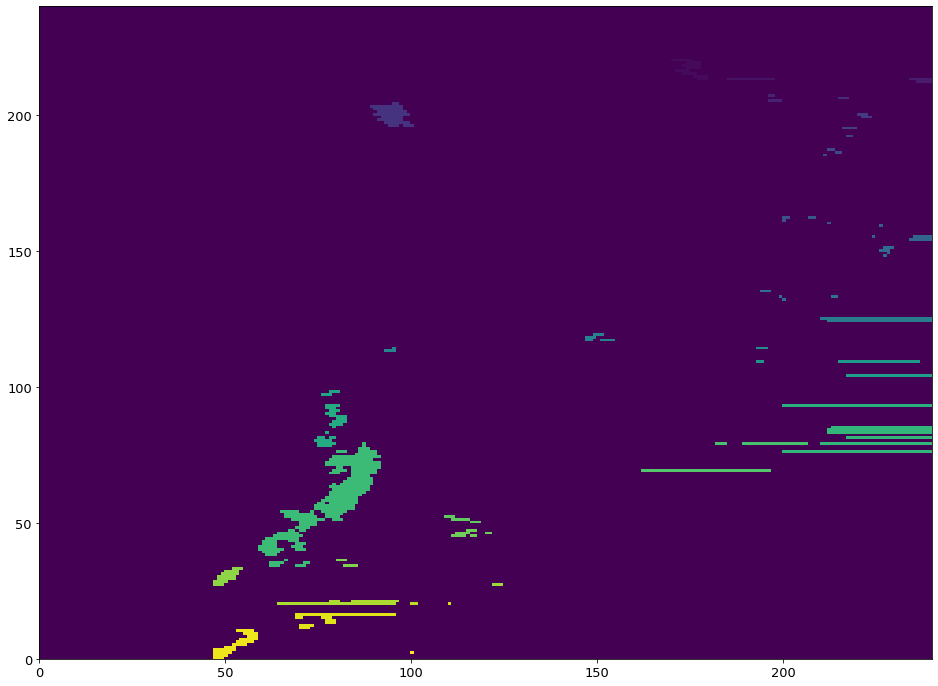

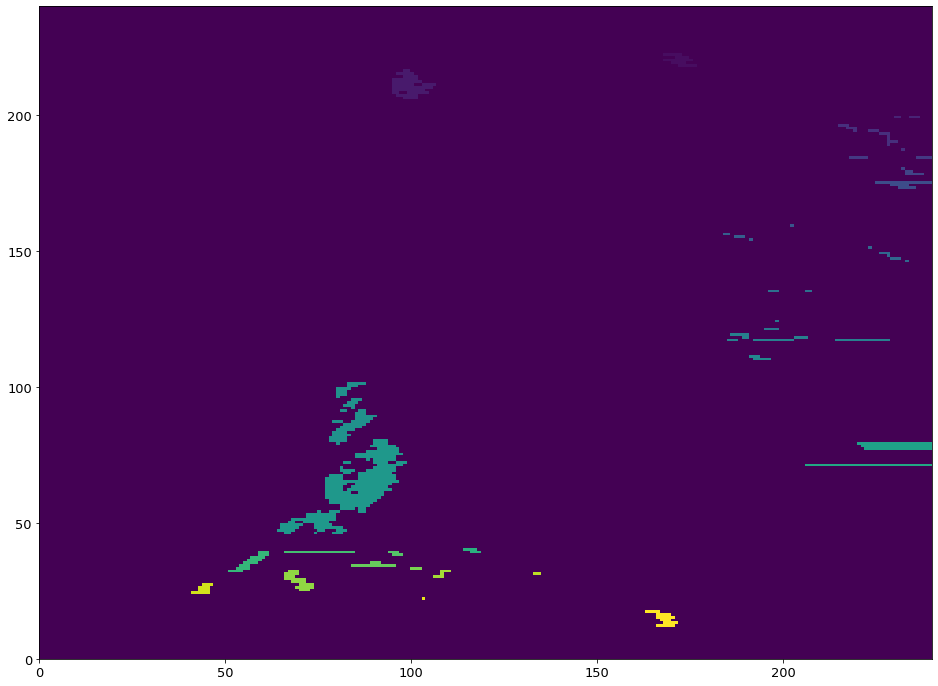

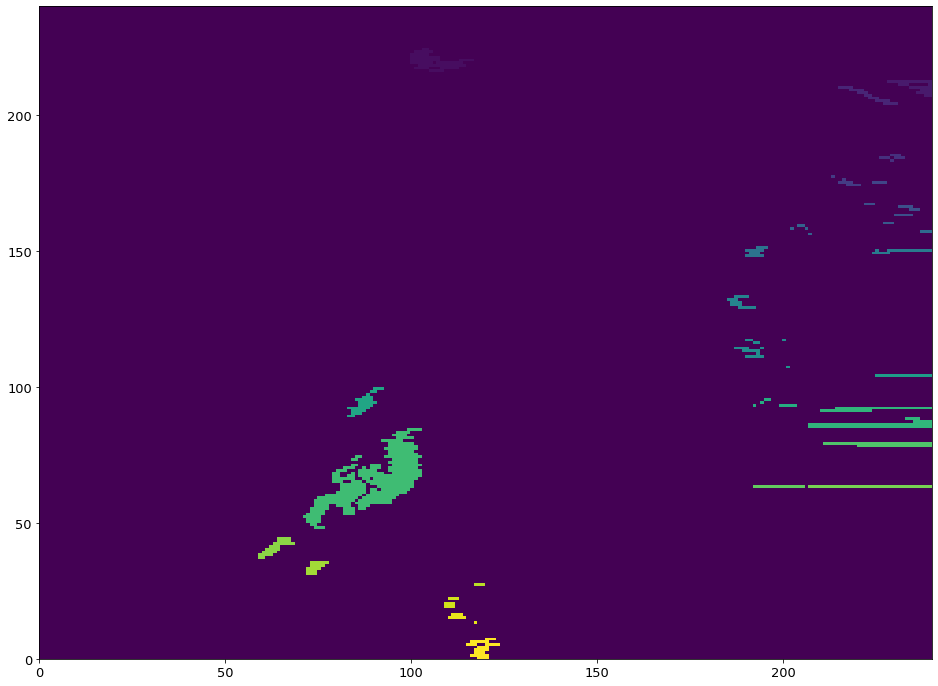

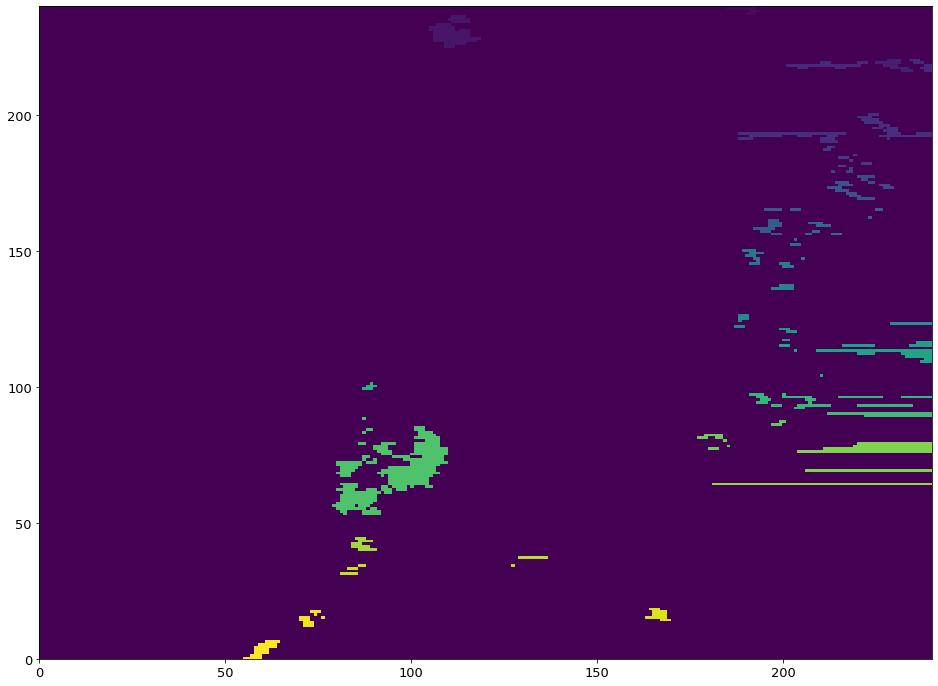

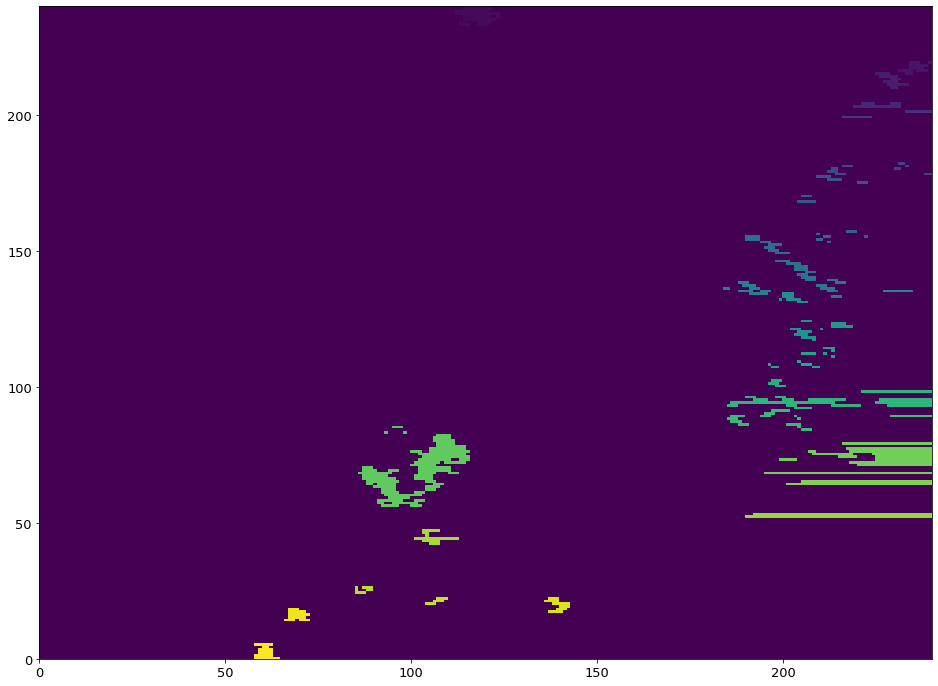

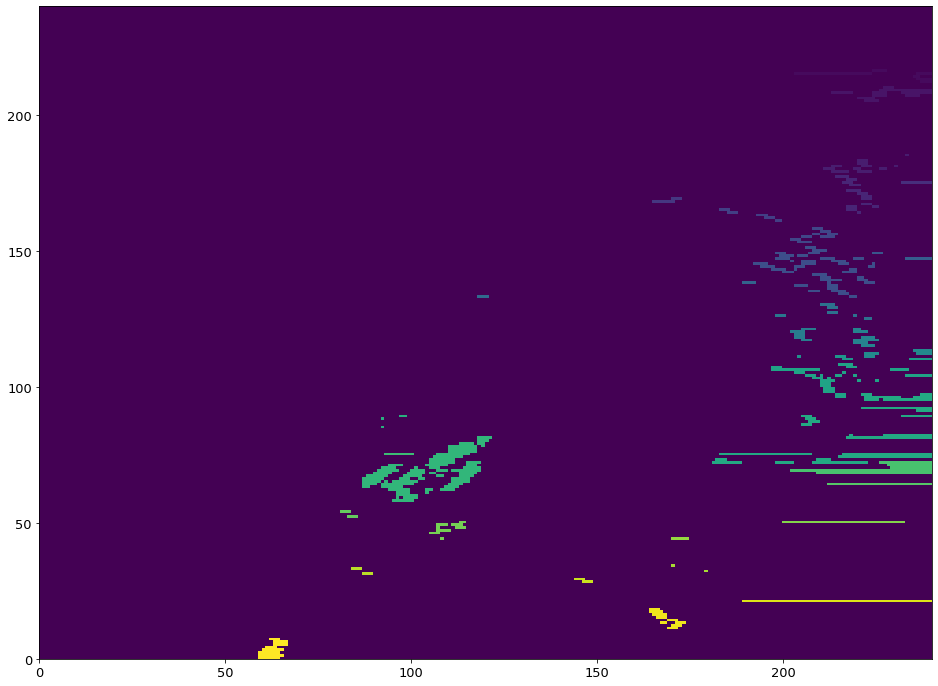

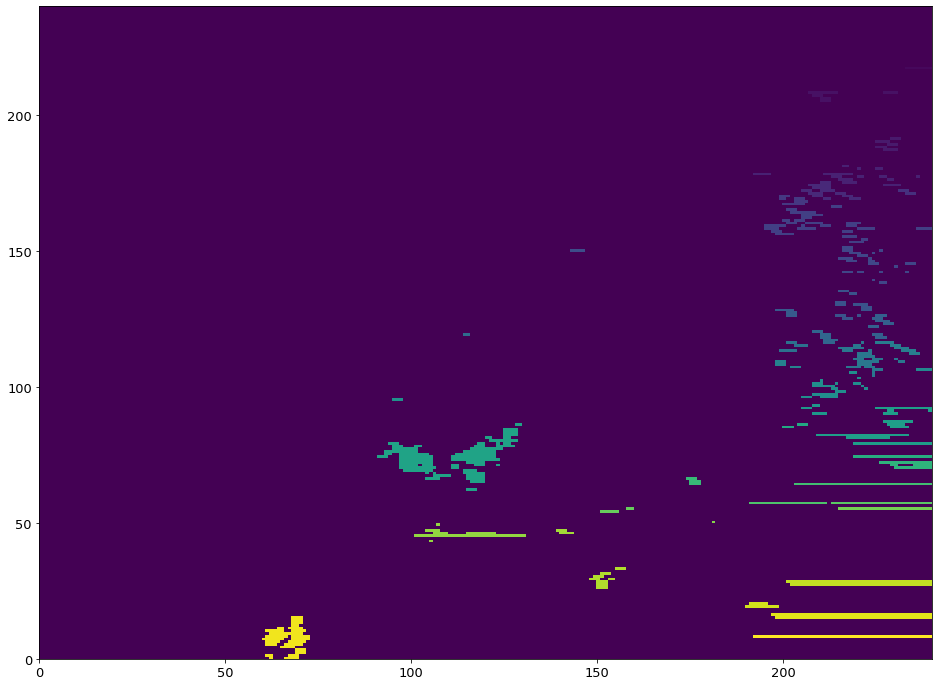

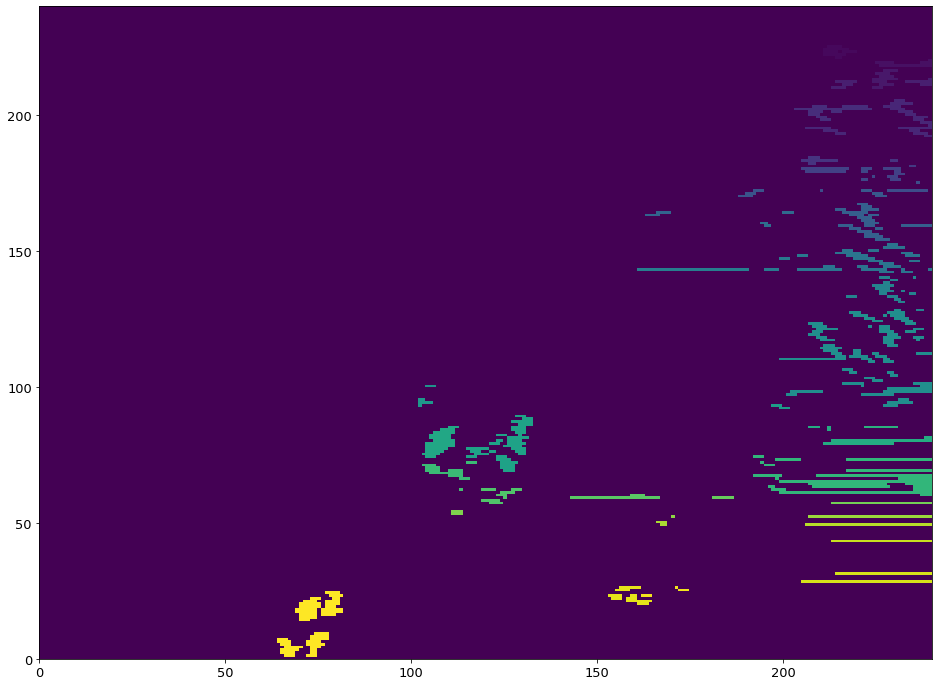

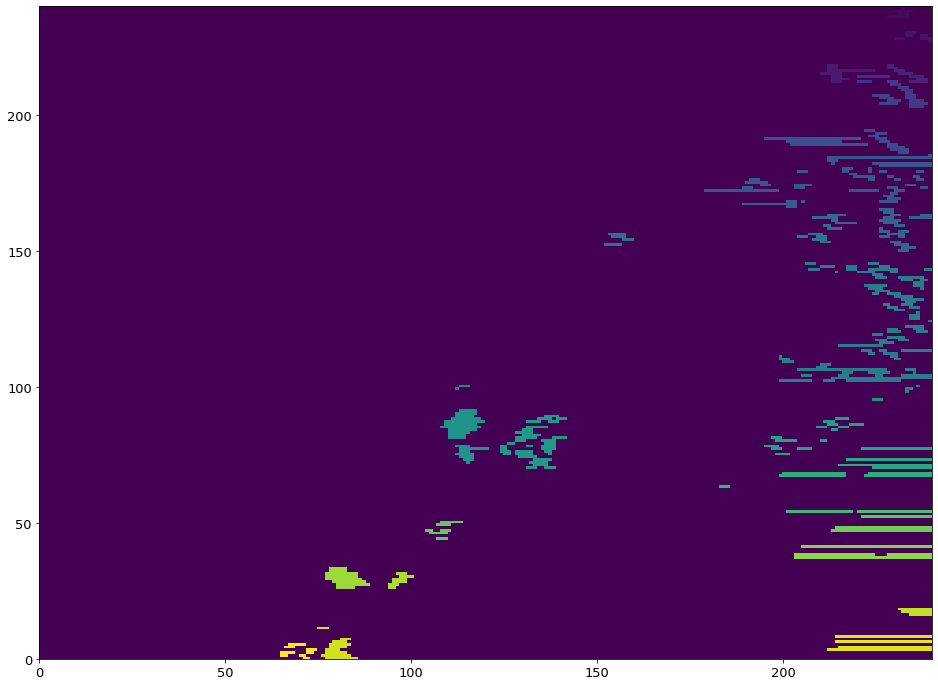

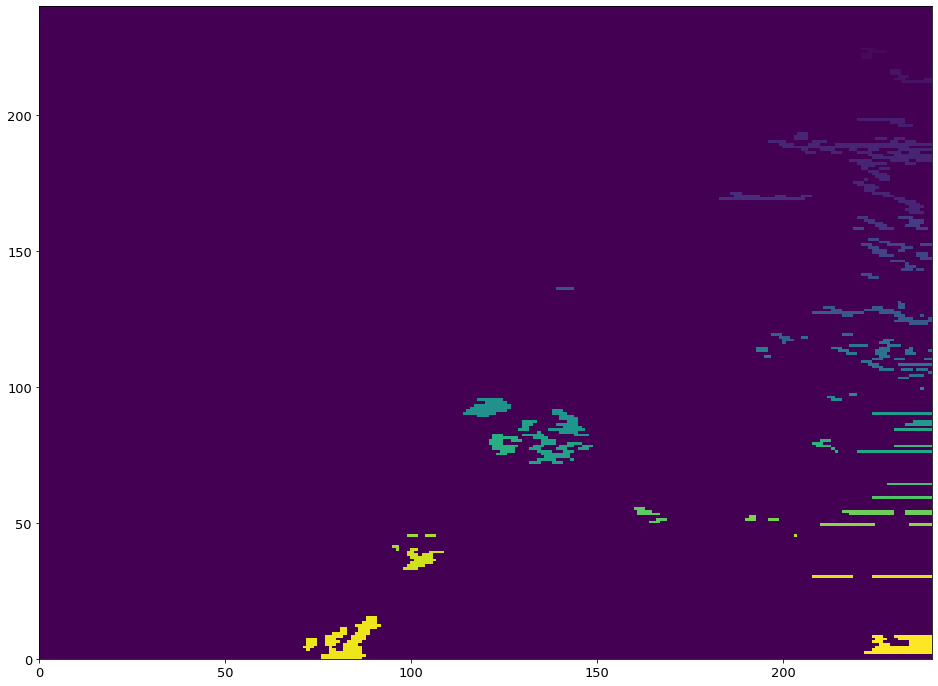

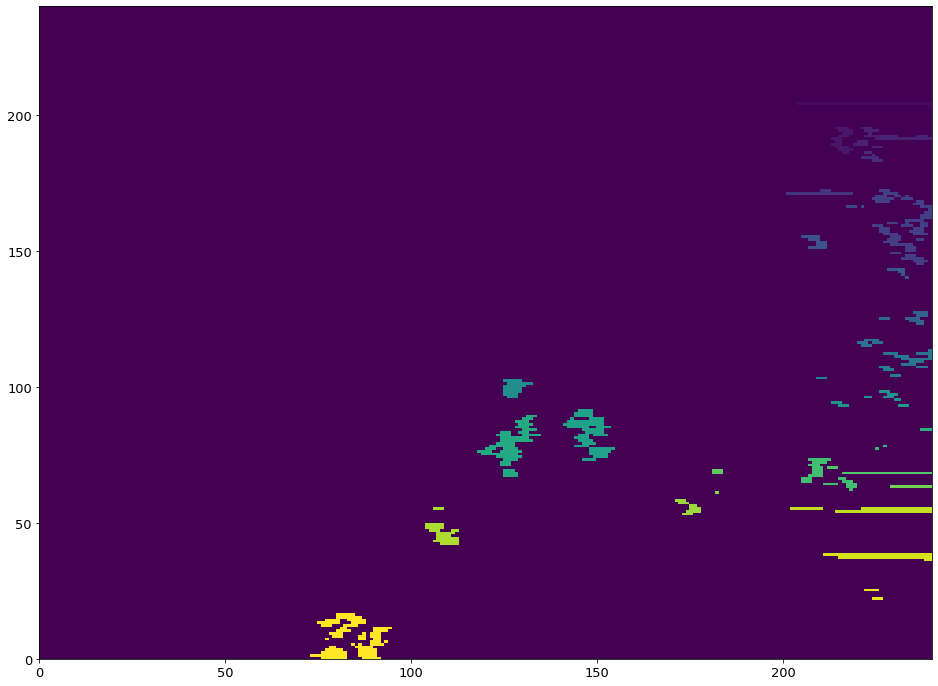

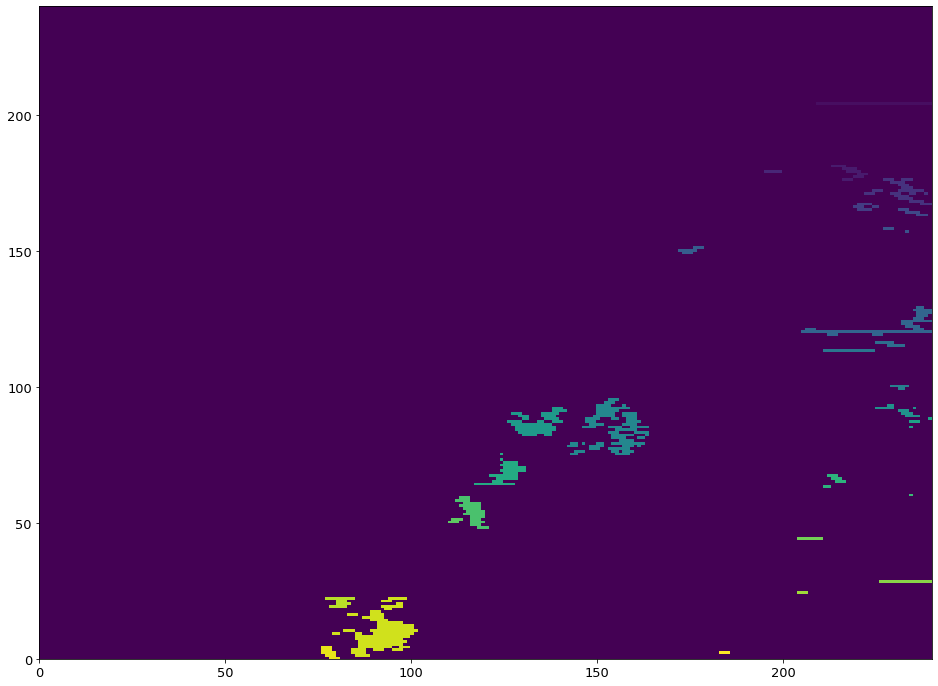

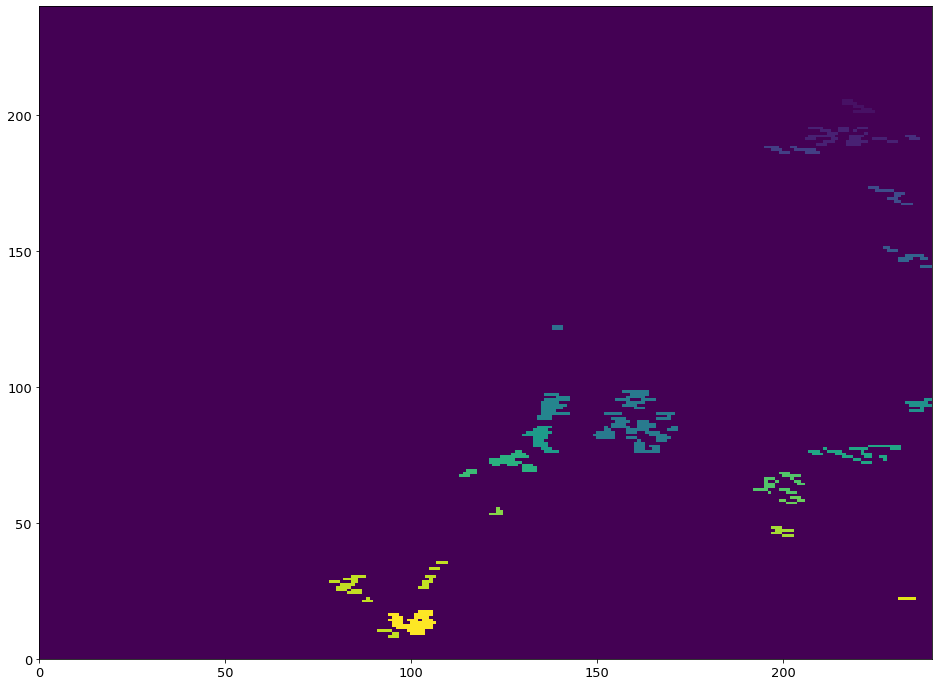

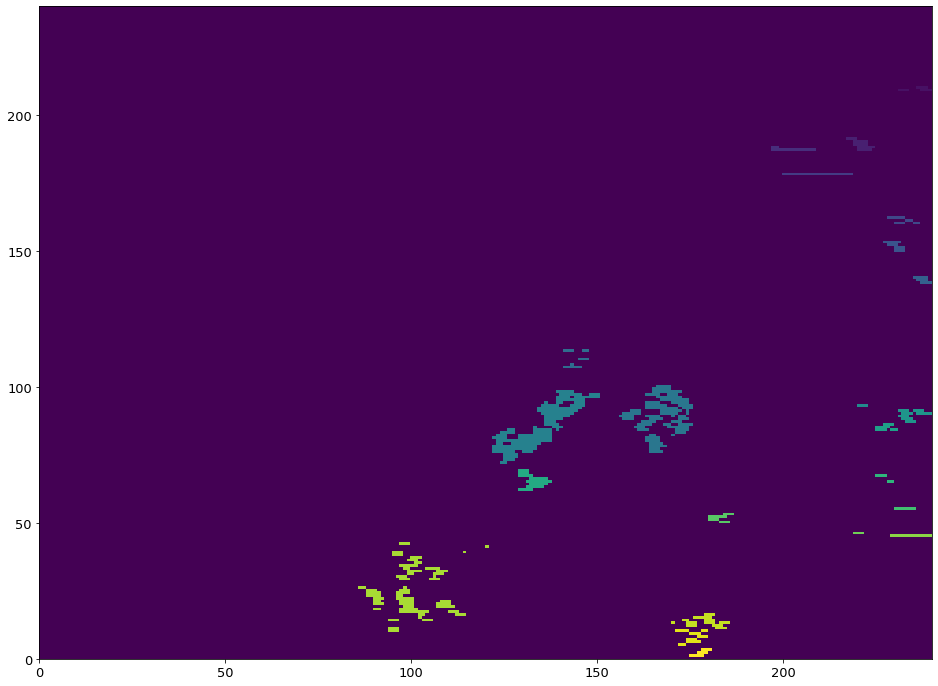

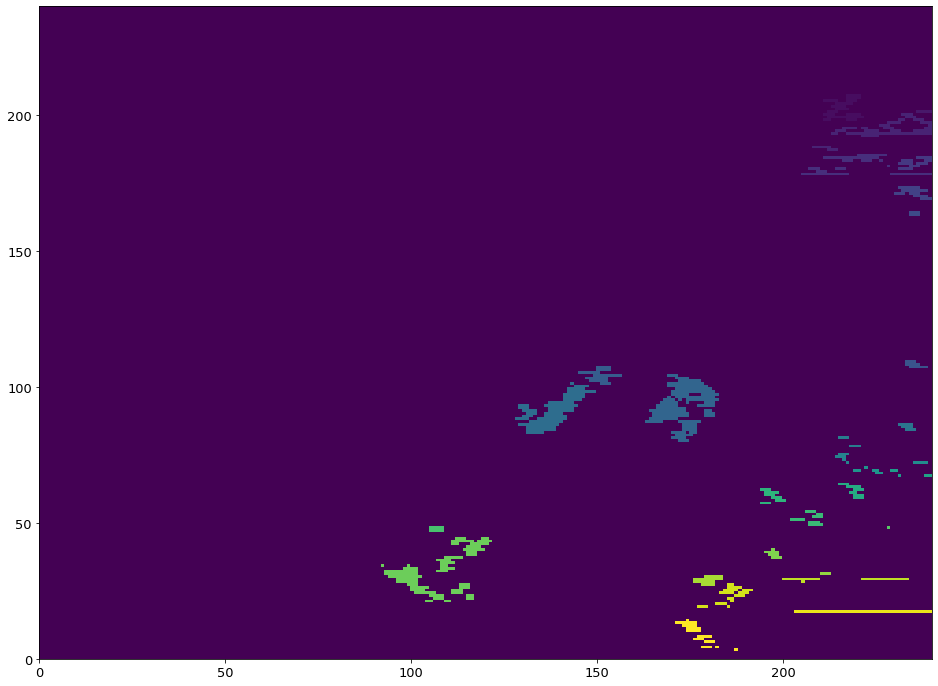

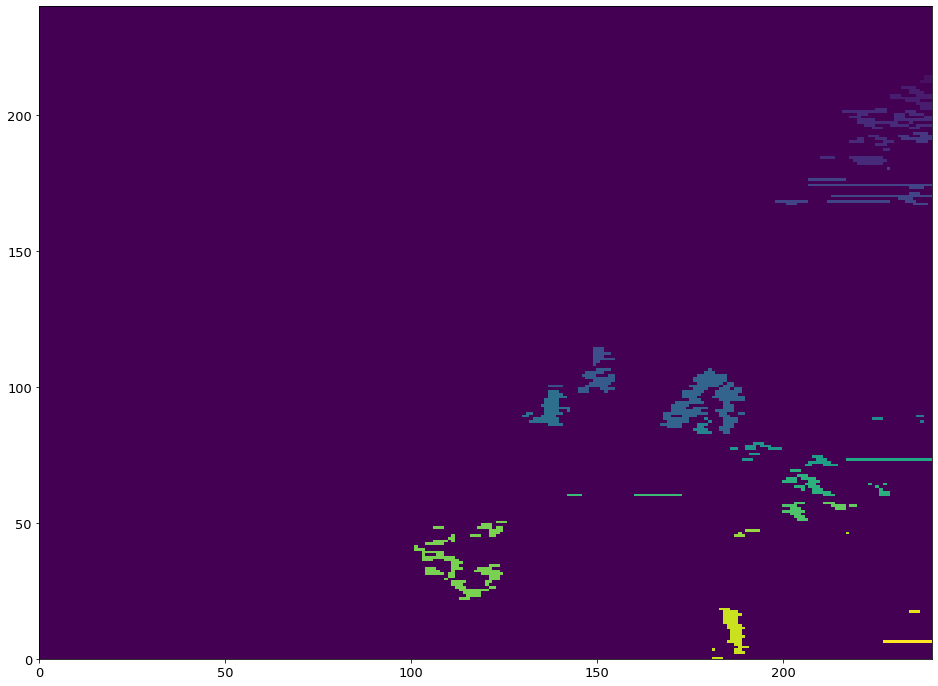

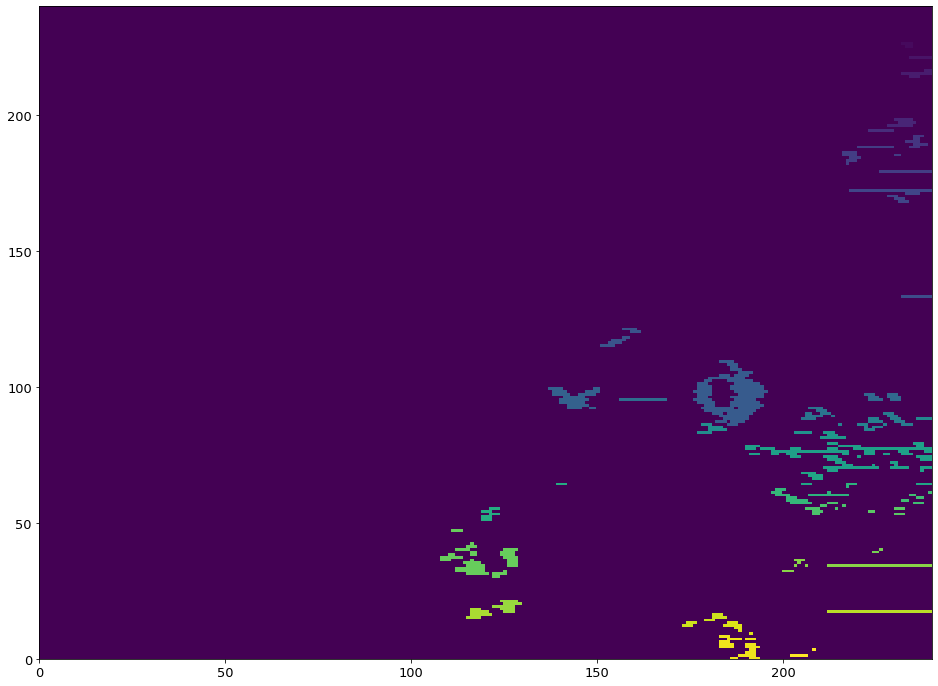

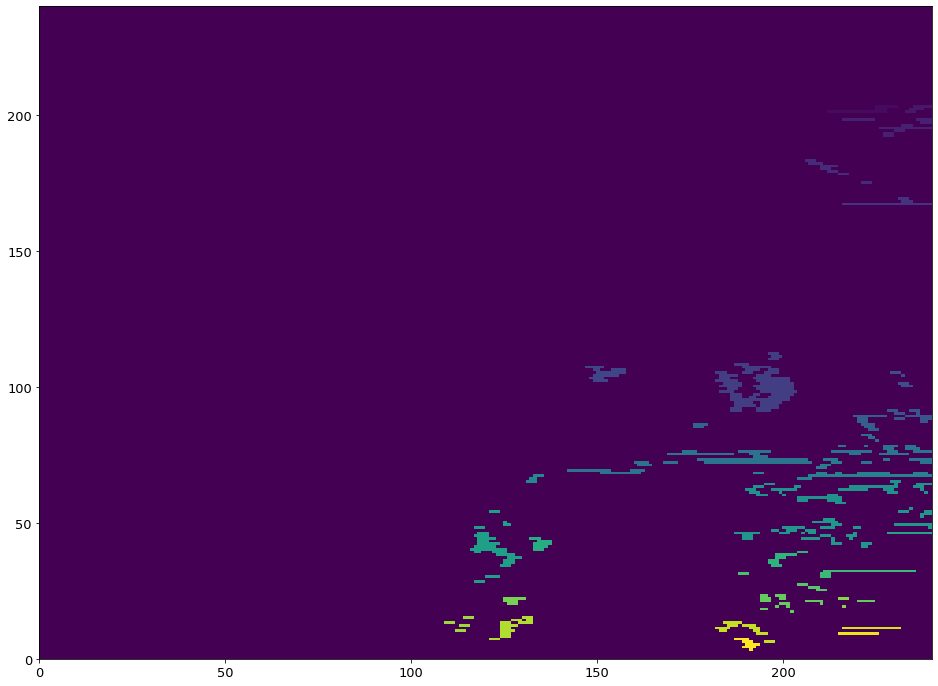

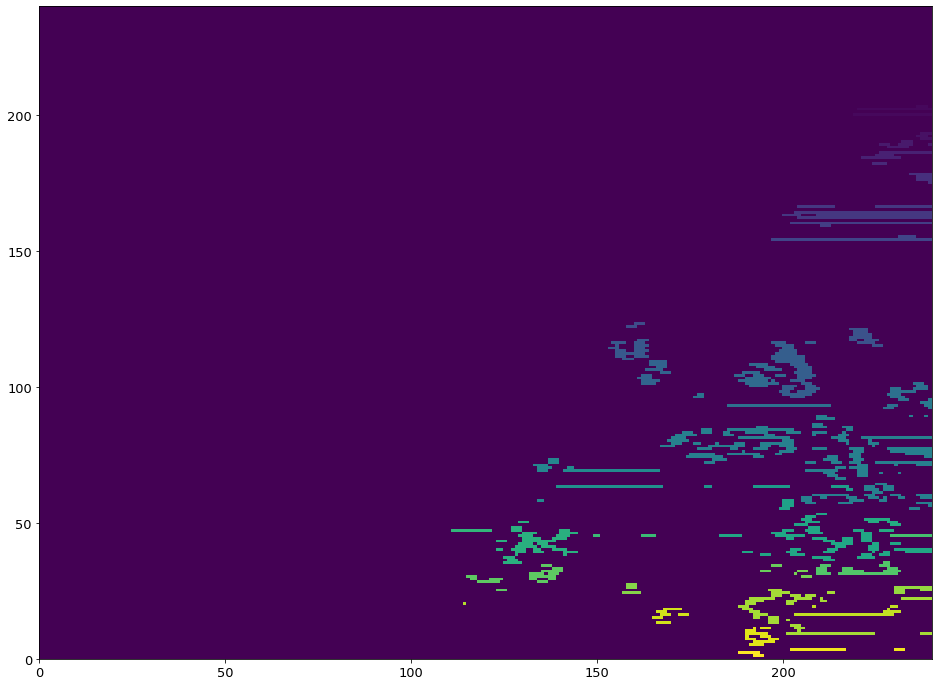

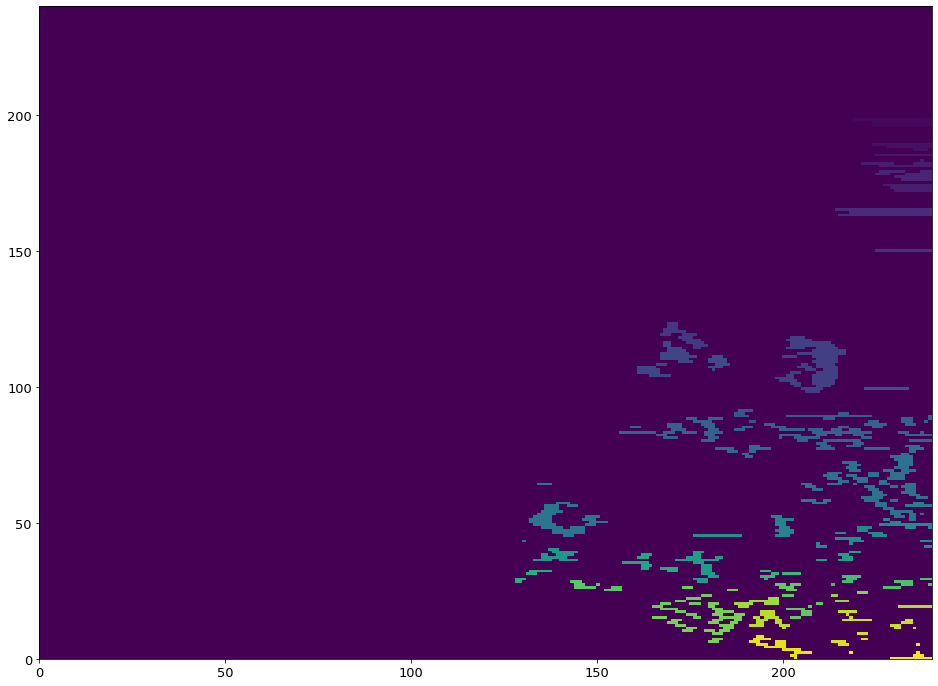

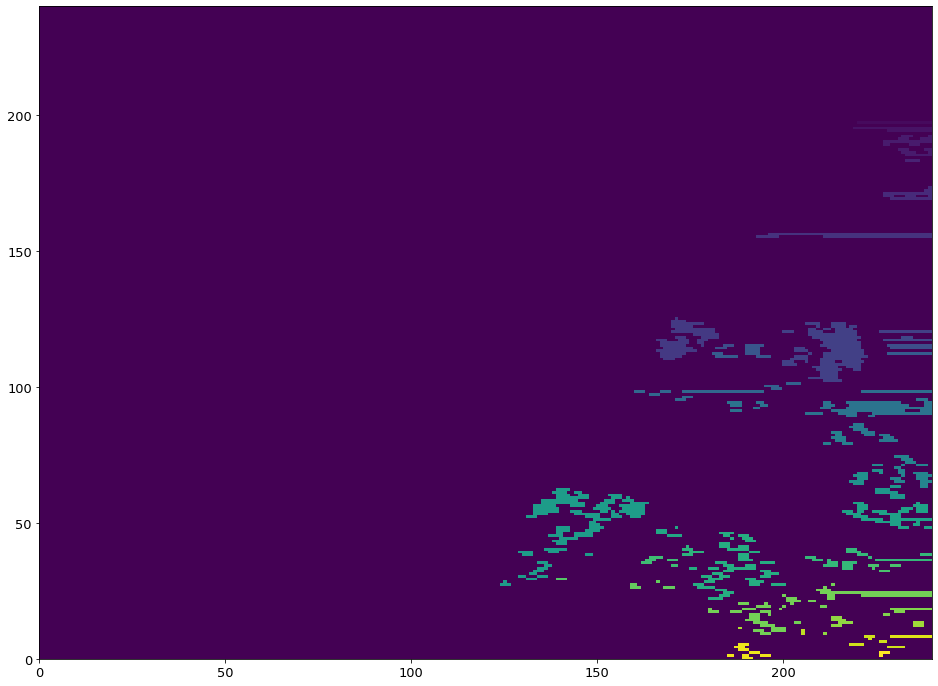

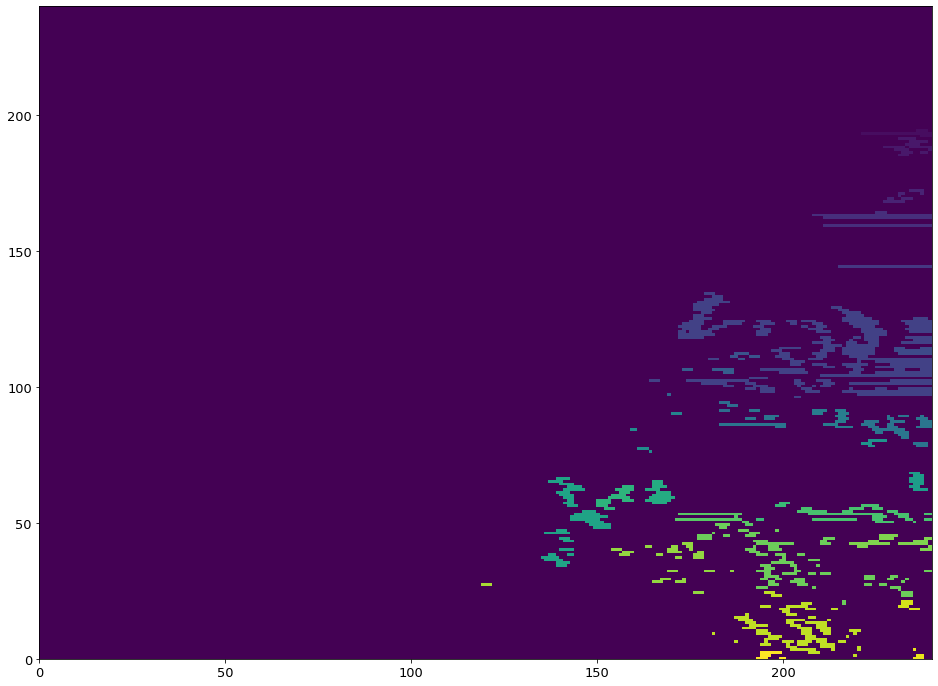

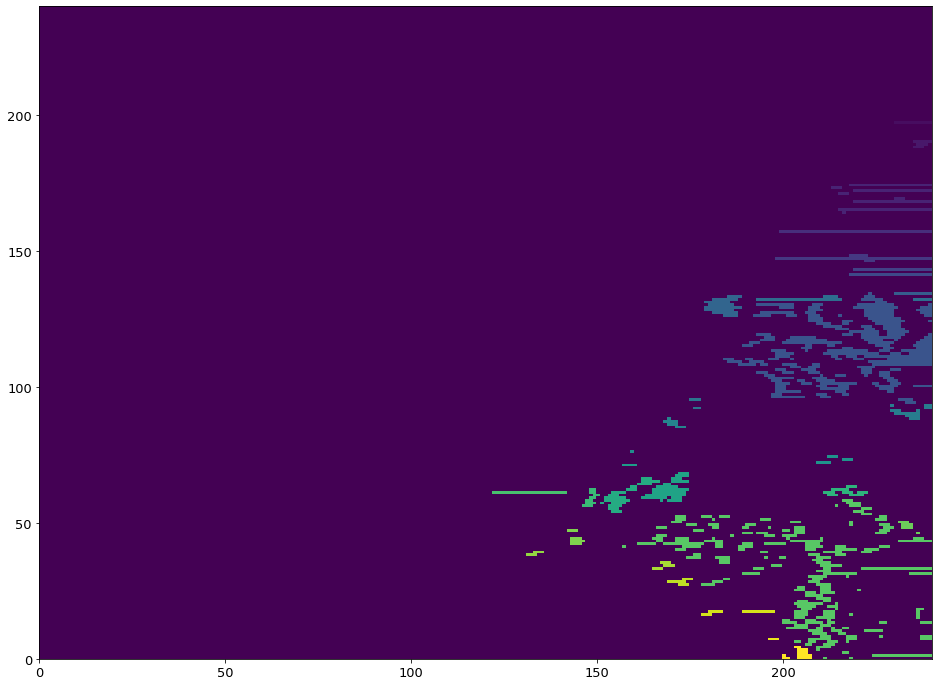

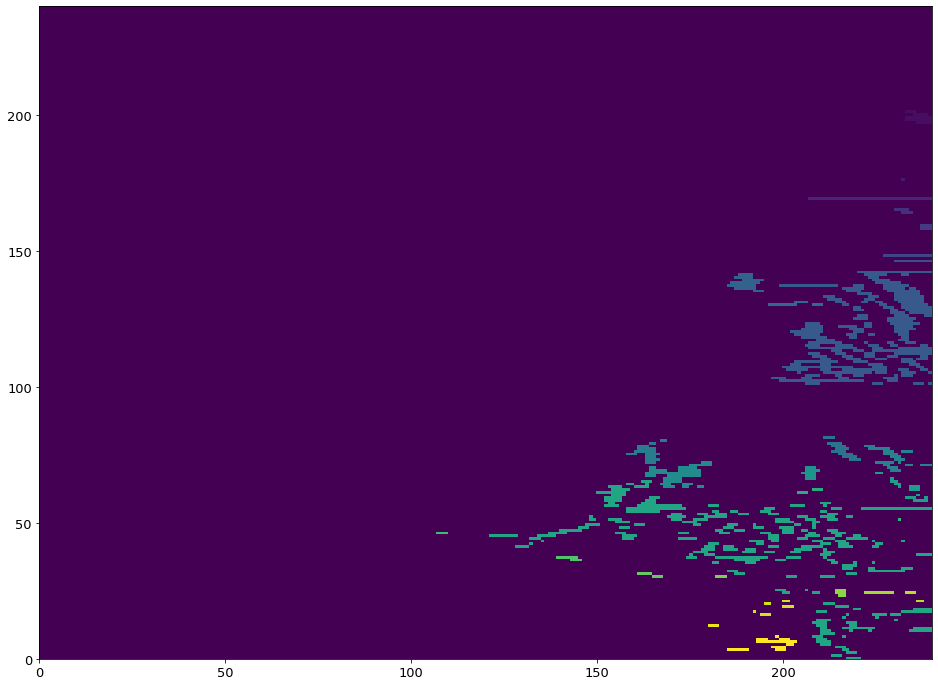

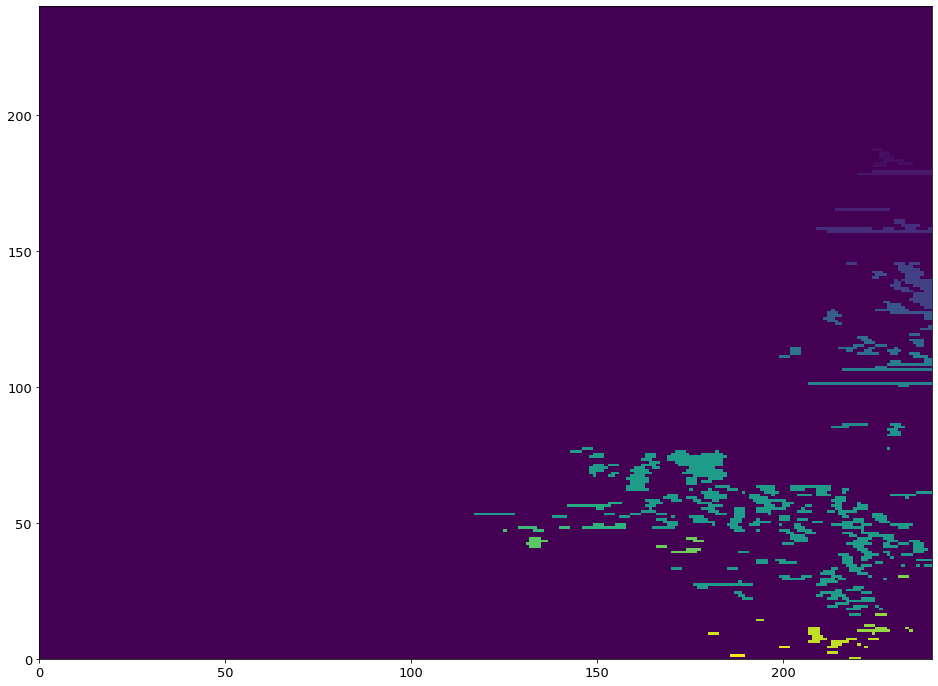

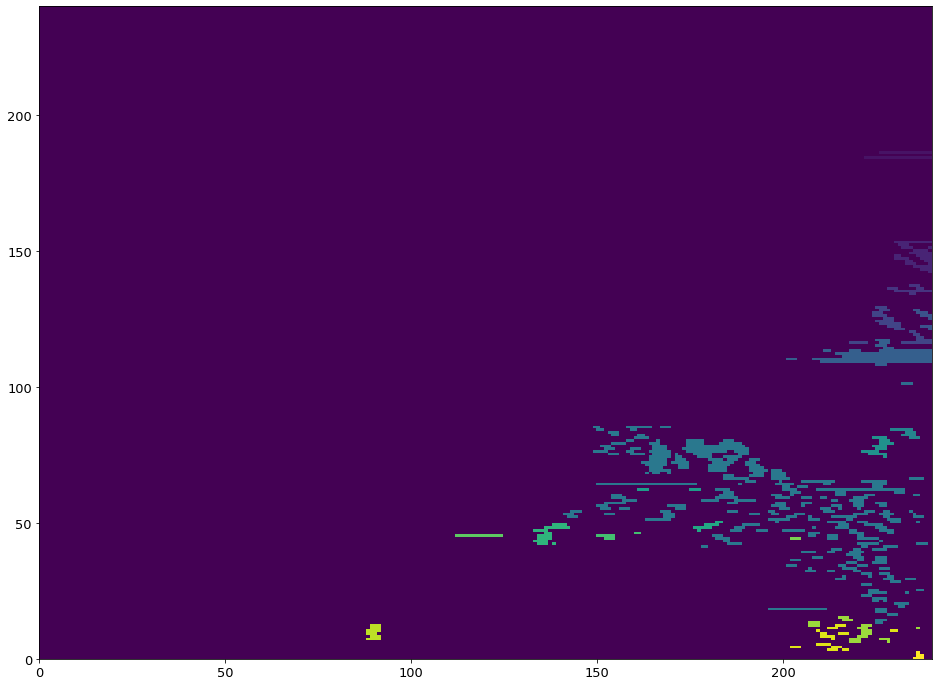

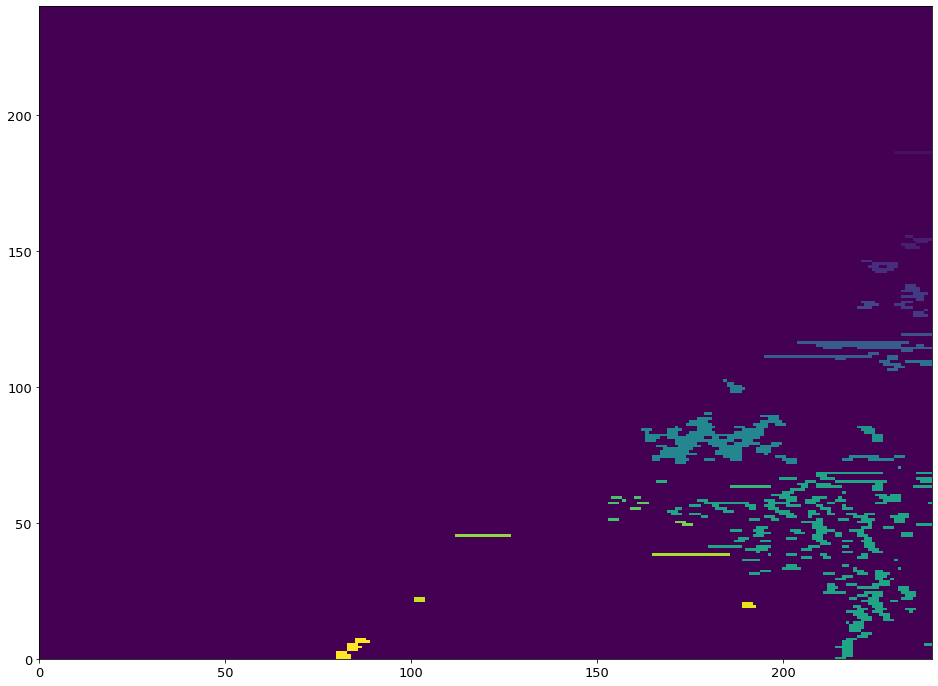

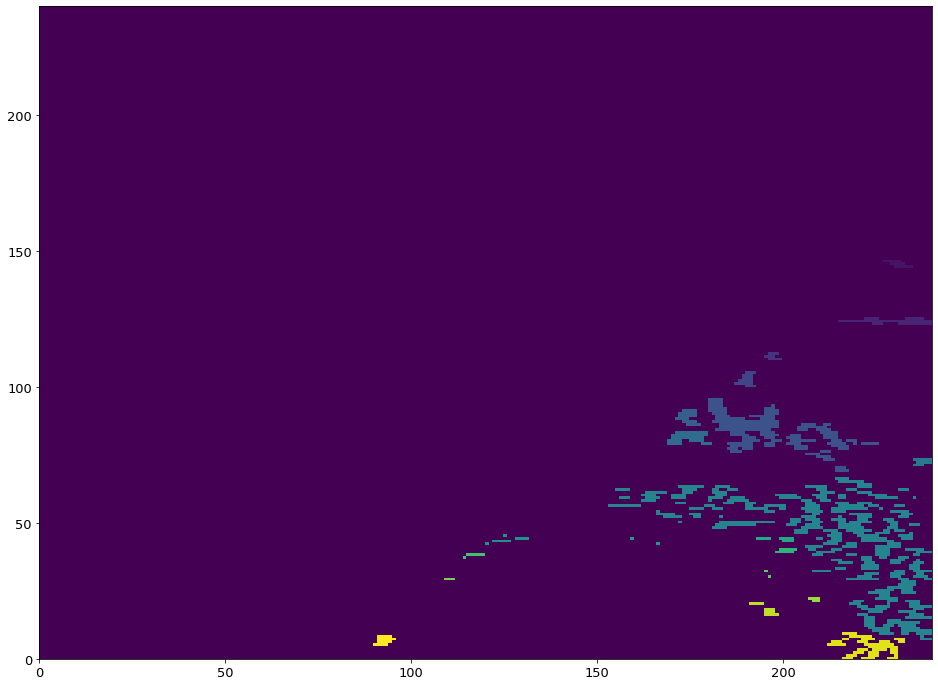

In [2]:
segmented_files = sorted(glob.glob('/Users/ms/Desktop/Radx_segmentation_direct_array/*.tiff'))
# plt.pcolormesh(np.rot90(cell_seg_labeled[1,:,::-1],axes=[0,1]))
for f in segmented_files:
    reader1 = AICSImage(f)
    dttt = reader1.data[0,0,:,:,:]

    cell_seg_labeled = skimage.measure.label(dttt)
    n_obj = len(regionprops(cell_seg_labeled))
    plt.pcolormesh(cell_seg_labeled[0,::-1,:])
    plt.show()

In [93]:
#  This part is important to understand and took me a while to actually grasp completely
# I had to store an RGB image from the output of gridding (could not use a simple binary image)
# Mainly because segmentation results identify separate objects in an RGB image much better.

# When I use plt.savefig to save the pcolormesh of ZDR field, matplotlib creates a figure with 
# margins etc around the actual data axes. Also, because I saved it as a TIFF file with a dpi=300,
# the number of pixels in the resulting image DO NOT indicate the actual physical length in the data coordinates.

# Thus, we need to calculate the # pixels that actually represent the physical dimensions of the grid. 
# For this purpose, I saved another plt.colormesh plot but this time with spines and axes features on
# Now, I can calculate the # pixels corresponding to the actual 120 km x and y dimensions of the grid using ImageJ.

# ImageJ reveals that the grid size of 120 km actually correspond to 2793 pixels in the x direction of the stack image.
# Since the y-dimension is smaller in our stack images, therefore, 1809 pixels in the y-direction correspond to 120 km.

x_resolution = 0.5 # in km
y_resolution = 0.5 # in km
z_resolution = 500 # in m, because z_res is also needed in calculation of zdr column heights

def calc_col_height(segmented_image,obj_id):
    """
    Function to calculate properties of identified ZDR columns
    in a 3D segmented image. Image segmentation performed using
    Allen Center 3D segmentation tool. 
    
    ## TODO: Sort the grid z limits and be consistent throughout. 
    
    Parameters:
    ___________
    segmented_image: Output from Allen Center 3D segmentation tool. This is 
    the array obtained after removing small objects from watershed algorithm output.
    
    e.g. segmented_image[0,::-1,:] makes it properly oriented N being towards actual N
    
    obj_id: Object ids are assumed to start from 1 onwards. This would pick the labelled object 
    from the segmented image.
    
    Important note: This function currently expects grids that span 
    from fzl level (4 km in this case) and above. Calculations of ZDR column 
    depth will vary because of this.
    
    Returns:
    _________
    The function returns object properties like total area (sum of object area at each z level),
    total volume, and object depth/height.
    """
    
    # We are concerned with ZDR depth/height only above the environmental freezing level
    
    segmented_image = np.ma.filled(segmented_image,-999)
    seg_rotated = segmented_image[:,::-1,:]
            
    df_final = pd.DataFrame()
    for i in range(segmented_image.shape[0]):
        try:
            df = pd.DataFrame(regionprops_table(seg_rotated[i,:,:],properties=['area','label']))
            df['z_level'] = i
            df.index = df['label']
            df_final = pd.concat([df_final,df],axis=1)
        except IndexError as error:                    # can happen when there are no objects left at and above a z-level
            break
    df_final = df_final.drop(labels=['label'],axis=1)

    z=0
    area=999999
    while area > 1:
        if z == seg_rotated.shape[0]:
            break  
        z += 1
        try:
            area = df_final.loc[obj_id]['area'].values[z] * x_resolution * y_resolution
        except KeyError as error:                      # can happen when there area has nan values (i.e. when zdr object does not exist at a z level)
            area = 0          
        except IndexError as error:                    # can happen when the zdr column still exists till the last z-level
            area = 0
            
#     print("height:",str(((z-1)*z_resolution)))
    return ((z-1)*z_resolution)

In [2]:
# This will create a napari viewer for the entire 4D (t,x,y,z) stack created for segmented images 

import napari
from dask_image.imread import imread
from skimage import measure
stack = imread("/Users/ms/Desktop/Radx_segmentation_direct_array/*.tiff")
from vispy.color import Colormap
import matplotlib.cm as cm
import pyart
%gui qt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [7]:
# sicne napari has limited colormaps and we want to use our custom colormap
cmap = cm.get_cmap('pyart_HomeyerRainbow', 15)
rgb_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    rgb_list.append(rgb)
rgb_list[0] = (0,0,0)

cmap = Colormap(rgb_list)

# define a function which reads only the last three dimensions since our stacked object is 4D
# concept credit: https://napari.org/tutorials/dask

def last3dims(f):
    # this is just a wrapper because the pycudadecon function
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        return f(array[0])[None,...]
    return func
    

label = last3dims(measure.label)

labeled = stack.map_blocks(label)

napari.view_image(labeled, contrast_limits=[0,15], colormap = ('HomeyerRainbow',cmap))

/anaconda3/envs/segmentation/lib/python3.6/site-packages/napari/utils/dask_utils.py:173: UserWarning: For best performance with Dask arrays in napari, please upgrade Dask to v2.15.0 or later. Current version is 2.9.0
  'For best performance with Dask arrays in napari, please '


In [17]:
# original code for interactive xarray compatibility available at https://anaconda.org/philippjfr/xarray_interactive/notebook

# Also, look at this open issue in xarray github repo: https://github.com/pydata/xarray/issues/3709

import abc

from panel.layout import Column, HSpacer, Row, VSpacer


class Interactive:

    __metaclass__ = abc.ABCMeta

    _fig = None

    def __init__(
        self,
        da,
        transform=None,
        plot=False,
        depth=0,
        loc="top_left",
        center=False,
        dmap=False,
        eager=True,
    ):
        self._name = da.name
        self._da = da
        self._method = None
        if transform is None:
            self._transform = hv.dim(self._name)
        else:
            self._transform = transform
        self._plot = plot
        self._depth = depth
        self._loc = loc
        self._center = center
        self._dmap = dmap
        self._eager = eager
        if eager:
            ds = hv.Dataset(self._da)
            self._current = self._transform.apply(ds, keep_index=True, compute=False)
        else:
            self._current = self._da

    @property
    def _params(self):
        return [v for k, v in self._transform.params.items() if k != "ax"]

    @property
    def _callback(self):
        @pn.depends(*self._params)
        def evaluate(*args, **kwargs):
            obj = self._transform.apply(
                hv.Dataset(self._da), keep_index=True, compute=False
            )
            if self._plot:
                return Interactive._fig
            else:
                return obj

        return evaluate

    def clone(
        self, transform=None, plot=None, loc=None, center=None, dmap=None, eager=None
    ):
        plot = self._plot or plot
        transform = transform or self._transform
        loc = self._loc if loc is None else loc
        center = self._center if center is None else center
        dmap = self._dmap if dmap is None else dmap
        eager = self._eager if eager is None else eager
        depth = self._depth + 1
        return Interactive(self._da, transform, plot, depth, loc, center, dmap, eager)

    def __dir__(self):
        return [d for d in dir(self._current) if d[0] != "_"]

    def __getattr__(self, name):
        if name in dir(self):
            self._method = name
            self.__doc__ = getattr(self._da, name).__doc__
            return self
        raise AttributeError(name)

    def __call__(self, *args, **kwargs):
        if self._method is None:
            if self._depth == 0:
                return self.clone(*args, **kwargs)
            raise AttributeError
        method = type(self._transform)(self._transform, self._method, accessor=True)
        return self.clone(method(*args, **kwargs))

    def _repr_mimebundle_(self, include=[], exclude=[]):
        return self.layout()._repr_mimebundle_()

    def layout(self):
        widget_box = pn.Column(
            *(
                p.owner
                for p in self._transform.params.values()
                if isinstance(p.owner, pn.widgets.Widget)
            )
        )
        panel = self.dmap() if self._dmap else self.panel()
        loc = self._loc
        if loc in ("left", "right"):
            widgets = Column(VSpacer(), widget_box, VSpacer())
        elif loc in ("top", "bottom"):
            widgets = Row(HSpacer(), widget_box, HSpacer())
        elif loc in ("top_left", "bottom_left"):
            widgets = Row(widget_box, HSpacer())
        elif loc in ("top_right", "bottom_right"):
            widgets = Row(HSpacer(), widget_box)
        elif loc in ("left_top", "right_top"):
            widgets = Column(widget_box, VSpacer())
        elif loc in ("left_bottom", "right_bottom"):
            widgets = Column(VSpacer(), widget_box)
        center = self._center
        if not widgets:
            if center:
                components = [HSpacer(), panel, HSpacer()]
            else:
                components = [panel]
        elif center:
            if loc.startswith("left"):
                components = [widgets, HSpacer(), panel, HSpacer()]
            elif loc.startswith("right"):
                components = [HSpacer(), panel, HSpacer(), widgets]
            elif loc.startswith("top"):
                components = [
                    HSpacer(),
                    Column(widgets, Row(HSpacer(), panel, HSpacer())),
                    HSpacer(),
                ]
            elif loc.startswith("bottom"):
                components = [
                    HSpacer(),
                    Column(Row(HSpacer(), panel, HSpacer()), widgets),
                    HSpacer(),
                ]
        else:
            if loc.startswith("left"):
                components = [widgets, panel]
            elif loc.startswith("right"):
                components = [panel, widgets]
            elif loc.startswith("top"):
                components = [Column(widgets, panel)]
            elif loc.startswith("bottom"):
                components = [Column(panel, widgets)]
        return Row(*components)

    def plot(self, *args, **kwargs):
        @pn.depends()
        def get_ax():
            from matplotlib.backends.backend_agg import FigureCanvas
            from matplotlib.pyplot import Figure

            Interactive._fig = fig = Figure()
            FigureCanvas(fig)
            return fig.subplots()

        kwargs["ax"] = get_ax
        transform = hv.dim(self._transform, "plot", accessor=True)
        return self.clone(transform(*args, **kwargs), plot=True)

    def eval(self):
        if self._eager:
            return self._current
        return self._callback()

    def hvplot(self, *args, **kwargs):
        transform = type(self._transform)(self._transform, "hvplot", accessor=True)
        return self.clone(transform(*args, **kwargs))

    def panel(self, **kwargs):
        return pn.panel(self._callback, **kwargs)

    def dmap(self):
        return hv.DynamicMap(self._callback)


xr.register_dataarray_accessor("interactive")(Interactive);

In [65]:
grid = xr.open_mfdataset(grid_files)

In [29]:
import hvplot.xarray
import panel as pn
import holoviews as hv

In [32]:
alt = pn.widgets.Player(name="alt", start=7, end=22, loop_policy="loop", interval=200)
# data_zdr["REF"].isel(z0=2).interactive.isel(start_time=time).hvplot(
#     cmap="viridis", width=800, height=500
# )

In [60]:
grid.ZDR.where(grid.ZDR >= 1).isel(time=8).interactive.isel(z0=alt).hvplot(cmap='viridis', width=800, height=500)

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


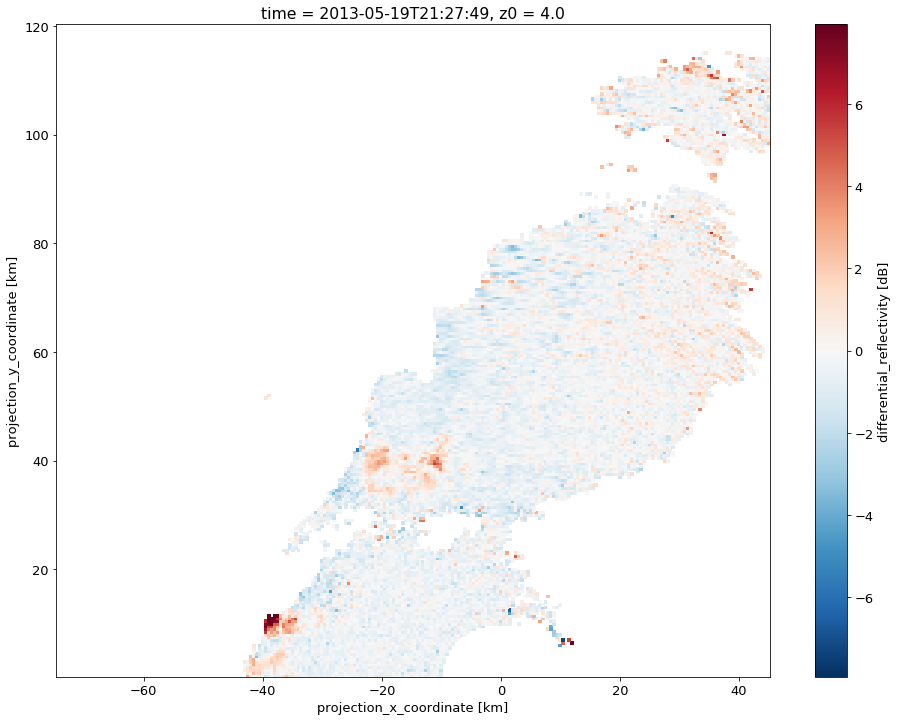

In [72]:
grid.ZDR.isel(time=19,z0=7).plot()

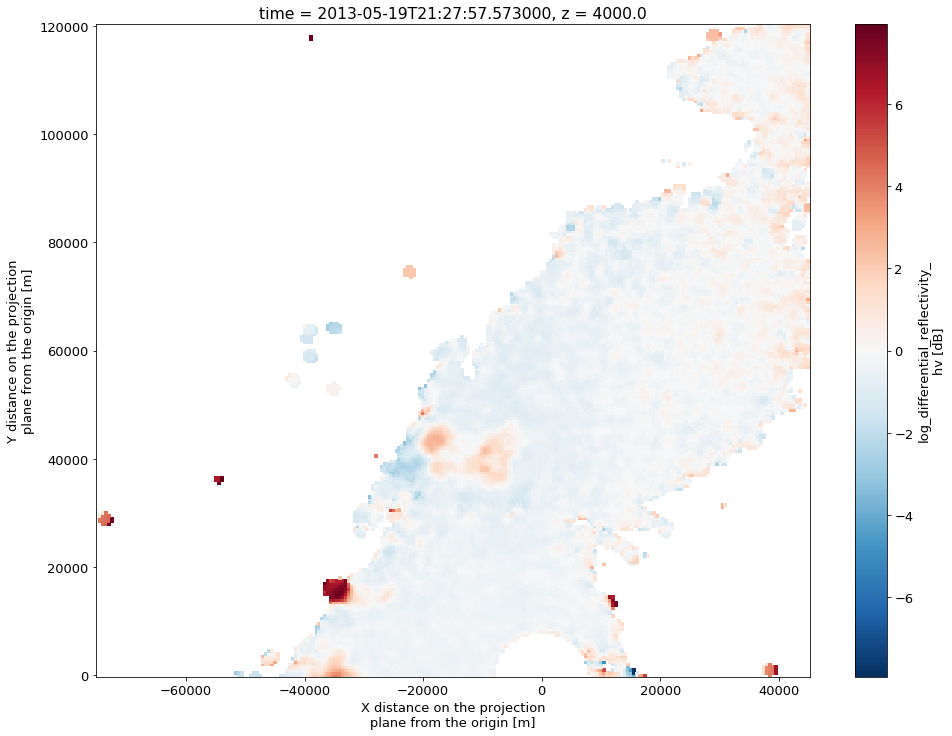

In [11]:
data['differential_reflectivity'].isel(time=20,z=8).plot()

In [9]:
data = xr.open_mfdataset(
    "/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc",
    parallel=True,
)
data

<xarray.Dataset>
Dimensions:                      (nradar: 1, time: 42, x: 241, y: 241, z: 31)
Coordinates:
  * time                         (time) datetime64[ns] 2013-05-19T20:02:36.05...
  * x                            (x) float64 -7.5e+04 -7.45e+04 ... 4.5e+04
  * y                            (y) float64 0.0 500.0 ... 1.195e+05 1.2e+05
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
Dimensions without coordinates: nradar
Data variables:
    origin_latitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_longitude             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_altitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    projection                   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ProjectionCoordinateSystem   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    radar_latitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_longitude              (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_altitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_time                   (time, nradar) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_name                   (time, nradar) |S4 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity                 (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    velocity                     (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_reflectivity    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    spectrum_width               (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_phase           (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    cross_correlation_ratio      (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    norm_coherent_power          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    unfolded_differential_phase  (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    phidp                        (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    kdp                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    ROI                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KTLX
    original_container:  NEXRAD Level II
    vcp_pattern:         12

In [23]:
from skimage import io

cell_seg_reader = io.imread(segmented_files[15])
cell_seg = cell_seg_reader
seg = label(cell_seg)
seg = np.fliplr(seg)

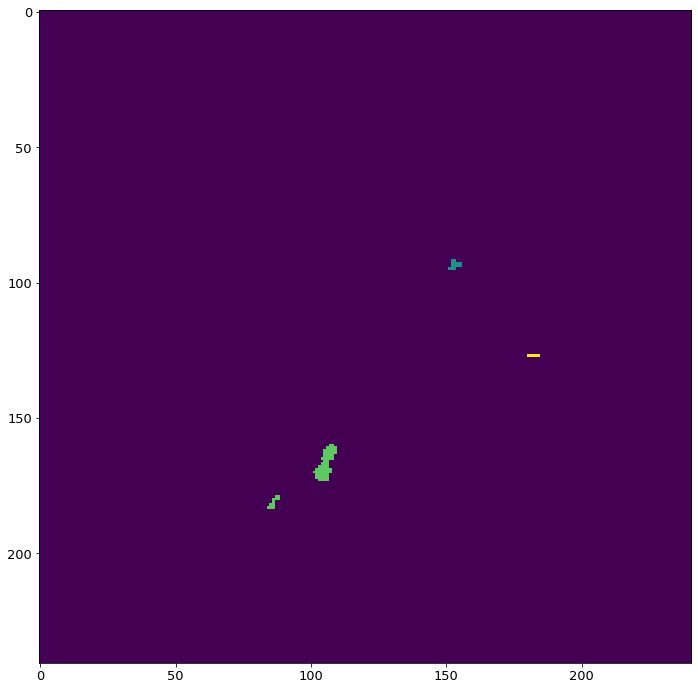

In [32]:
plt.imshow(seg[3,::-1,:])

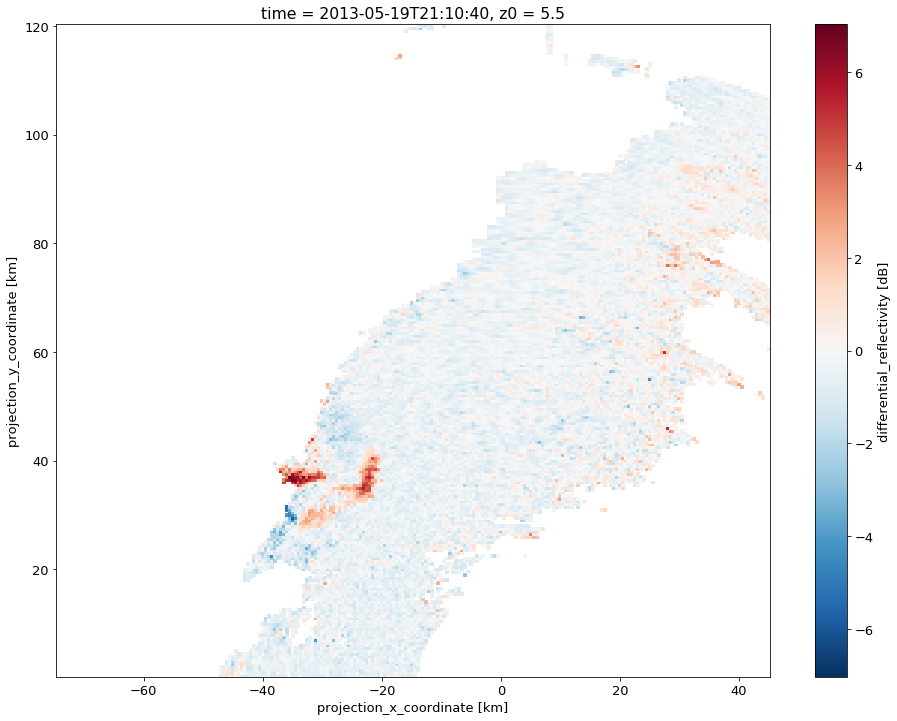

In [31]:
grid.ZDR.squeeze().isel(z0=10).plot()

In [15]:
cell_seg_reader = io.imread(segmented_files[15])
cell_seg = cell_seg_reader
seg = label(cell_seg)
seg = np.fliplr(seg)

ax.pcolormesh(seg[0, :, :], cmap="Greys", alpha=0.7)
fig = ax.pcolormesh(
    flash_dataset[i, :, :],
    cmap=cmap,
    alpha=alpha,
    vmin=vmin,
    vmax=vmax,
)

try:
    obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])

    if len(obj_bounds.columns) == 1:
        obj = obj_bounds.transpose()
        rect = patches.Rectangle(
            (obj["bbox-2"][0], obj["bbox-1"][0]),
            obj["bbox-5"][0] - obj["bbox-2"][0],
            obj["bbox-4"][0] - obj["bbox-1"][0],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.annotate(
            obj["label"][0],
            (obj["bbox-5"][0], obj["bbox-4"][0]),
            color="k",
            weight="bold",
            fontsize=10,
            ha="center",
            va="center",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        cbar = plt.colorbar(mappable=fig)
        cbar.set_label(cbar_label,
            fontsize=20,
            labelpad=16,
        )
        ratio = 1
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)
        ax.set_xticklabels(
            ["-75", "-50", "-25", "0", "25"]
        )  # since #grid cells = 241 correspond to half the distance dx=dy=500m
        ax.set_yticklabels(["0", "25", "50", "75", "100"])
        ax.set_xlabel("Distance from KTLX <- West (km) East ->")
        ax.set_ylabel("Distance from KTLX <- South (km) North ->")
        fsavename = segmented_files[i].split("/")[-1].split(".")[0]
        raw_title = datetime.strptime(
            segmented_files[i].split("/")[-1].split(".")[0], "%H%M%S"
        )
        final_title = datetime.strftime(raw_title, "%H%M:%S") + " UTC"

        plt.title(f"Time = {final_title}")
        plt.show()

    if len(obj_bounds.columns) > 1:
        for j in range(len(obj_bounds)):
            obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
            rect = patches.Rectangle(
                (obj["bbox-2"][0], obj["bbox-1"][0]),
                obj["bbox-5"][0] - obj["bbox-2"][0],
                obj["bbox-4"][0] - obj["bbox-1"][0],
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            ax.annotate(
                obj["label"][0],
                (obj["bbox-5"][0], obj["bbox-4"][0]),
                color="k",
                weight="bold",
                fontsize=10,
                ha="center",
                va="center",
            )
            # Add the patch to the Axes
            ax.add_patch(rect)
        #                 ax.colorbar()
        cbar = plt.colorbar(mappable=fig)
        cbar.set_label(cbar_label,
            fontsize=20,
            labelpad=16,
        )
        ratio = 1
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)
        ax.set_xticklabels(
            ["-75", "-50", "-25", "0", "25"]
        )  # since #grid cells = 241 correspond to half the distance dx=dy=500m
        ax.set_yticklabels(["0", "25", "50", "75", "100"])
        ax.set_xlabel("Distance from KTLX <- West (km) East ->")
        ax.set_ylabel("Distance from KTLX <- South (km) North ->")
        fsavename = segmented_files[i].split("/")[-1].split(".")[0]
        raw_title = datetime.strptime(
            segmented_files[i].split("/")[-1].split(".")[0], "%H%M%S"
        )
        final_title = datetime.strftime(raw_title, "%H%M:%S") + " UTC"

        plt.title(f"Time = {final_title}")
        plt.show()

except KeyError as error:  # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
    continue

IndentationError: unexpected indent (<ipython-input-15-3da467ff671b>, line 2)

In [35]:
grid = xr.open_dataset(grid_files[9])

In [36]:
grid.time.comment.replace(':','_')

'2013-05-19T20_45_04Z'

/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/anaconda3/envs/segmentation/lib/p

PermissionError: [Errno 1] Operation not permitted: '/Users/ms/Desktop/mount/May_19_2013_all_stuff/Radx_stacks/2013-05-19T21_36_21Z/'

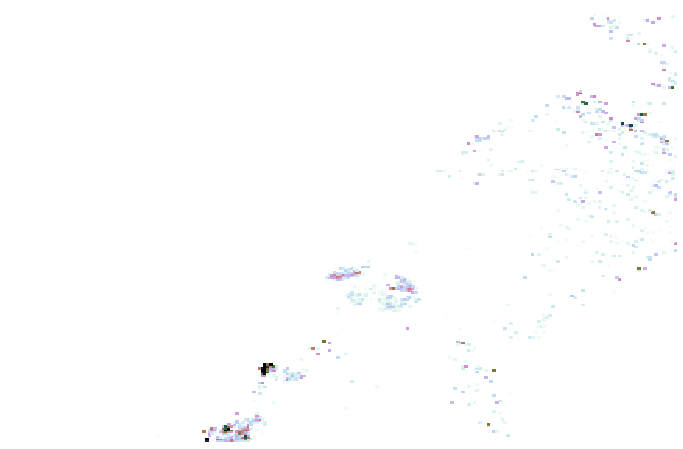

In [5]:
frz_lvl = 4

for f in grid_files:
    grid = xr.open_dataset(f)
    
    # We will save tiff files for grid levels only above freezing level
    lvl_start = np.searchsorted(grid.z0.data,frz_lvl)
    lvl_end = lvl_start + 15
    
#     lvl_start = 0 #need stacks from surface to comment of low-level ZDR/KDP statistics (see MvLW, 2016)
#     lvl_end = lvl_start + 8 
    
    for j in np.arange(lvl_start,lvl_end):
        plt.figure(figsize=(12,8))
        data = grid.ZDR.squeeze().data[j,::-1,:]
        data_zdr_thresh = np.ma.masked_where(data < 1,data)
        fig = plt.pcolormesh(data_zdr_thresh[::-1,:],cmap='cubehelix_r',vmin=1,vmax=7)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        plot_tim = grid.time.comment.replace(':','_')
        base_dir = '/Users/ms/Desktop/mount/May_19_2013_all_stuff/Radx_stacks/'
        plot_dir = base_dir + plot_tim + '/'
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        plt.savefig(plot_dir +  '{:d}.tiff'.format(j))
#         with tifffile.TiffWriter(f'{plot_dir}/{j}.tiff') as tif:
#             tif.save(data_zdr_thresh)
        plt.close()

In [7]:
#create and save stack from individual z-level tiff files for each radar volume 
root, dirs, files = next(os.walk("/Users/ms/Desktop/mount/May_19_2013_all_stuff/Radx_stacks/"))
for d in dirs:
    with tifffile.TiffWriter('/Users/ms/Desktop/mount/May_19_2013_all_stuff/Radx_stacks/original_img_stacks/Stack_{}.tif'.format(d)) as stack:
        for filename in natsorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/Radx_stacks/{}/*.tiff'.format(d))):
            stack.save(tifffile.imread(filename), photometric='rgb')